In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import skimage
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

model_path = os.path.join(models_base_path, "mnist_continuous_alldigits/2/epoch_90_ckpt.pth")

In [5]:
classes = list(range(10))
branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.4854854854854855, 1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 0.44744744744744747, 0.4854854854854855), ((2, 3, 4, 5, 6, 7, 8, 9), 0.43343343343343343, 0.44744744744744747), ((2, 3, 4, 5, 7, 8, 9), 0.4164164164164164, 0.43343343343343343), ((3, 4, 5, 7, 8, 9), 0.3743743743743744, 0.4164164164164164), ((3, 4, 5, 8, 9), 0.3683683683683684, 0.3743743743743744), ((3, 4, 5, 9), 0.35235235235235235, 0.3683683683683684), ((3, 4, 5), 0.3483483483483483, 0.35235235235235235), ((3, 5), 0.27127127127127126, 0.3483483483483483), ((0,), 0, 0.4854854854854855), ((1,), 0, 0.44744744744744747), ((6,), 0, 0.43343343343343343), ((2,), 0, 0.4164164164164164), ((7,), 0, 0.3743743743743744), ((8,), 0, 0.3683683683683684), ((9,), 0, 0.35235235235235235), ((4,), 0, 0.3483483483483483), ((5,), 0, 0.27127127127127126), ((3,), 0, 0.27127127127127126)]

# classes = [0, 4, 9]
# branch_defs = [
#     ((0, 4, 9), 0.5, 1),
#     ((0,), 0, 0.5),
#     ((4, 9), 0.35, 0.5),
#     ((4,), 0, 0.35),
#     ((9,), 0, 0.35)
# ]

input_shape = (1, 28, 28)

In [6]:
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

In [7]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/mnist_hybrid_transmutation"

os.makedirs(out_path, exist_ok=True)

In [8]:
branch_point_examples = [
    (4, 9, 0.3483483483483483),
    (1, 7, 0.3743743743743744),
    (3, 5, 0.27127127127127126)
]

### Create data loader

In [9]:
dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

In [10]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Import the model

In [11]:
model = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat, model_path
).to(DEVICE)

### Hybrids

Branch point between 4 and 9


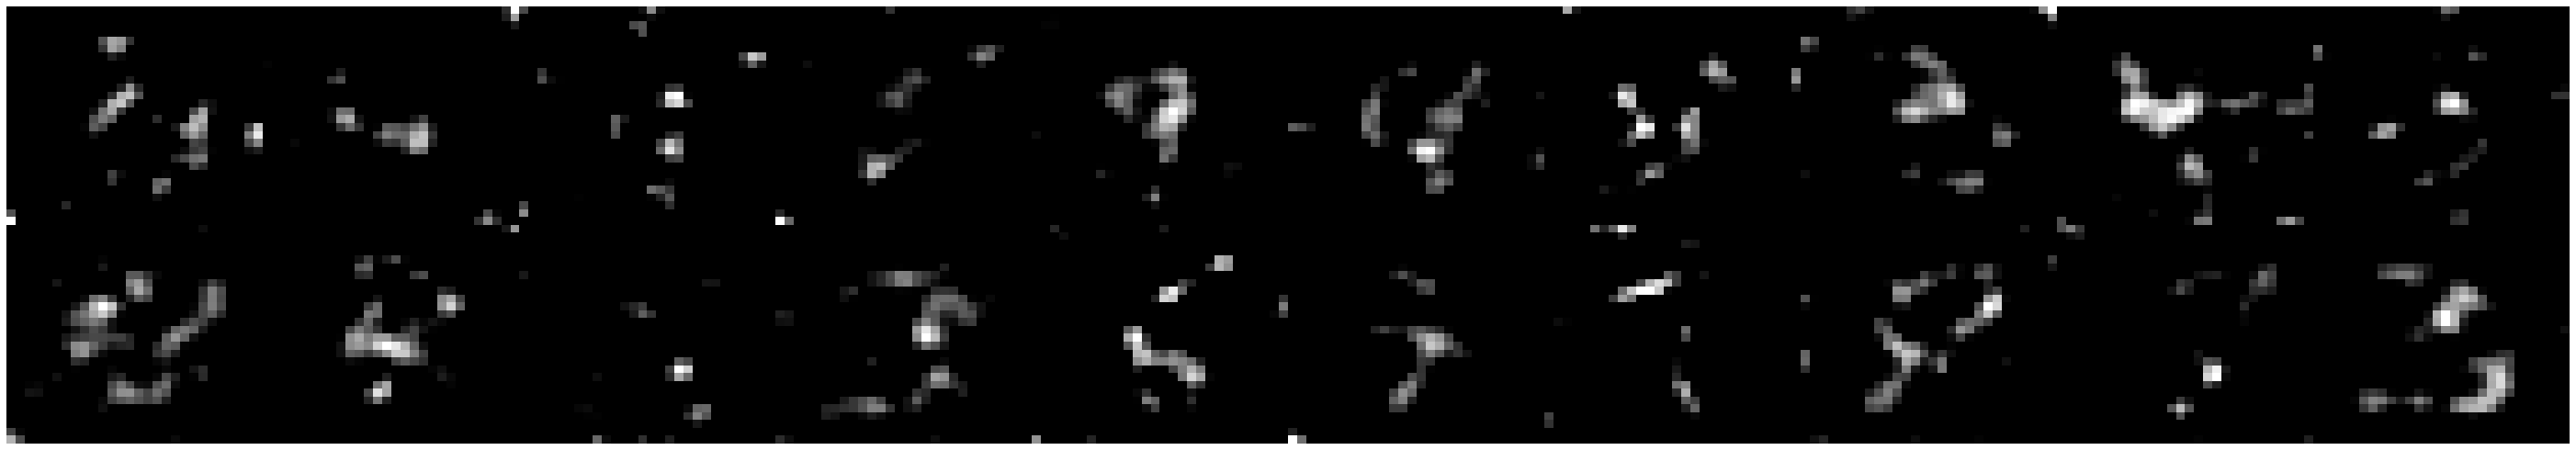

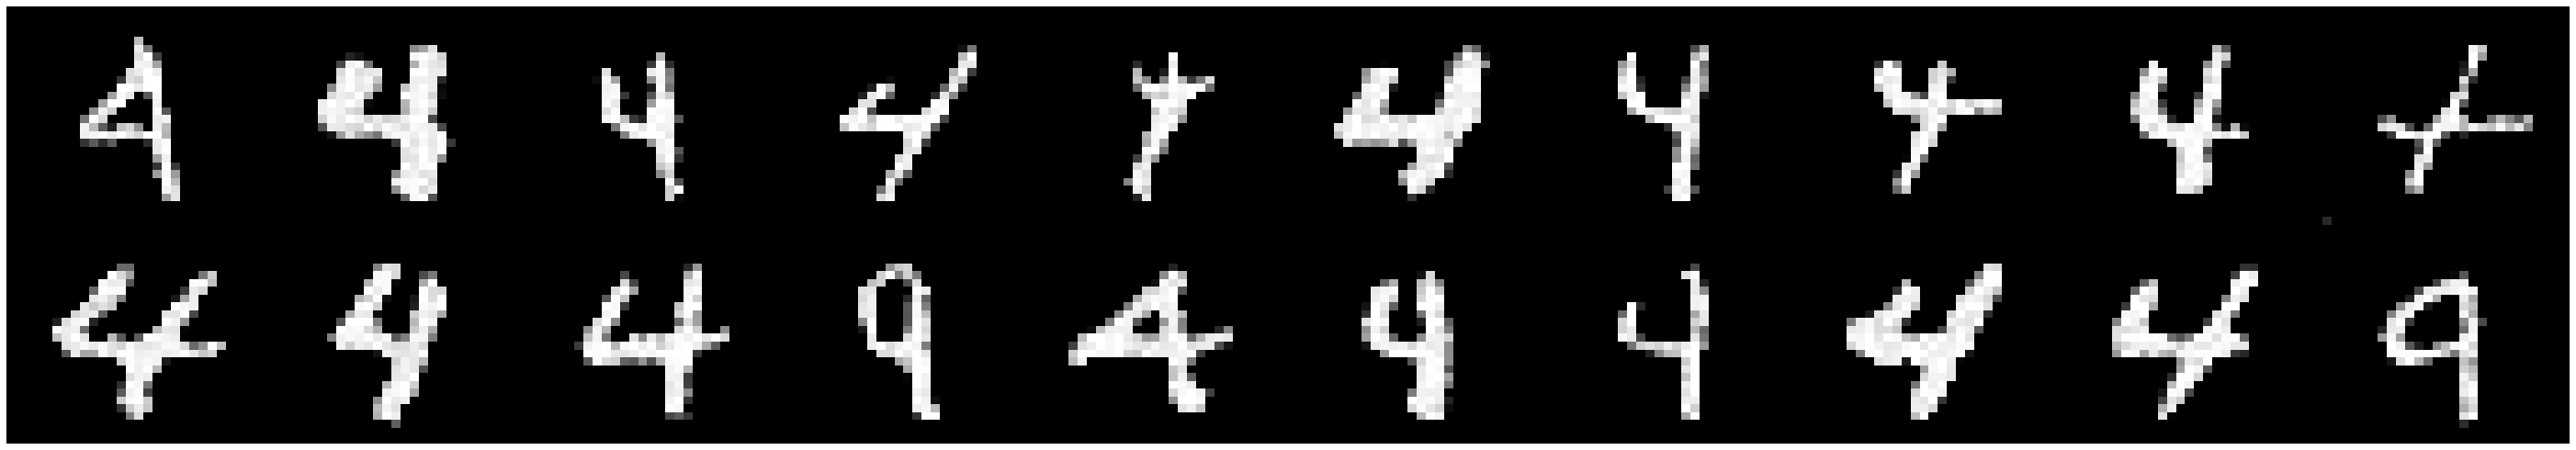

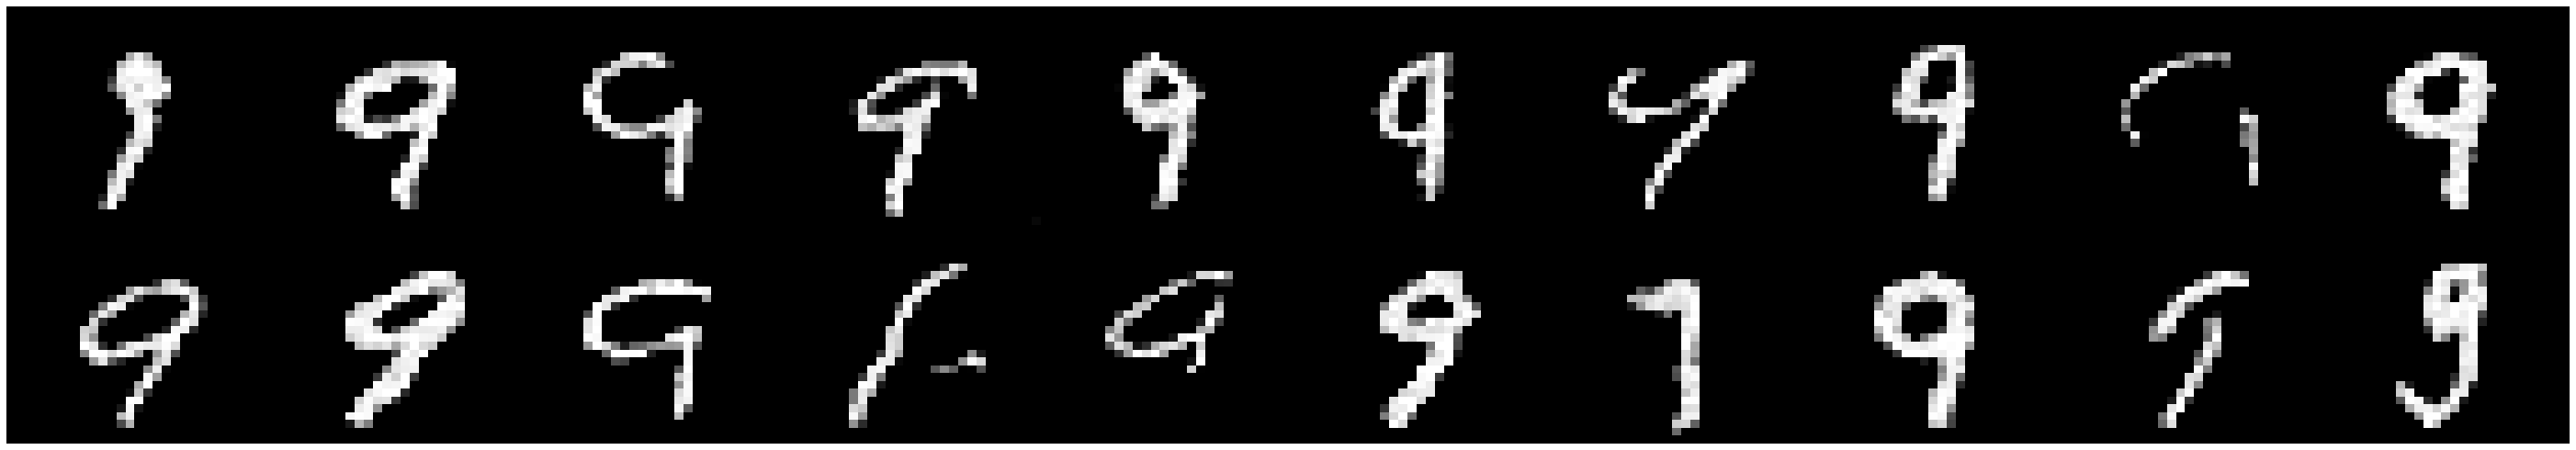

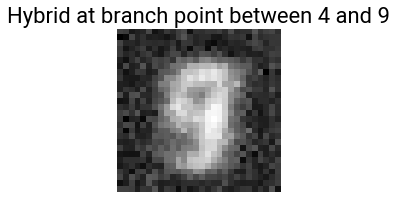

Branch point between 1 and 7


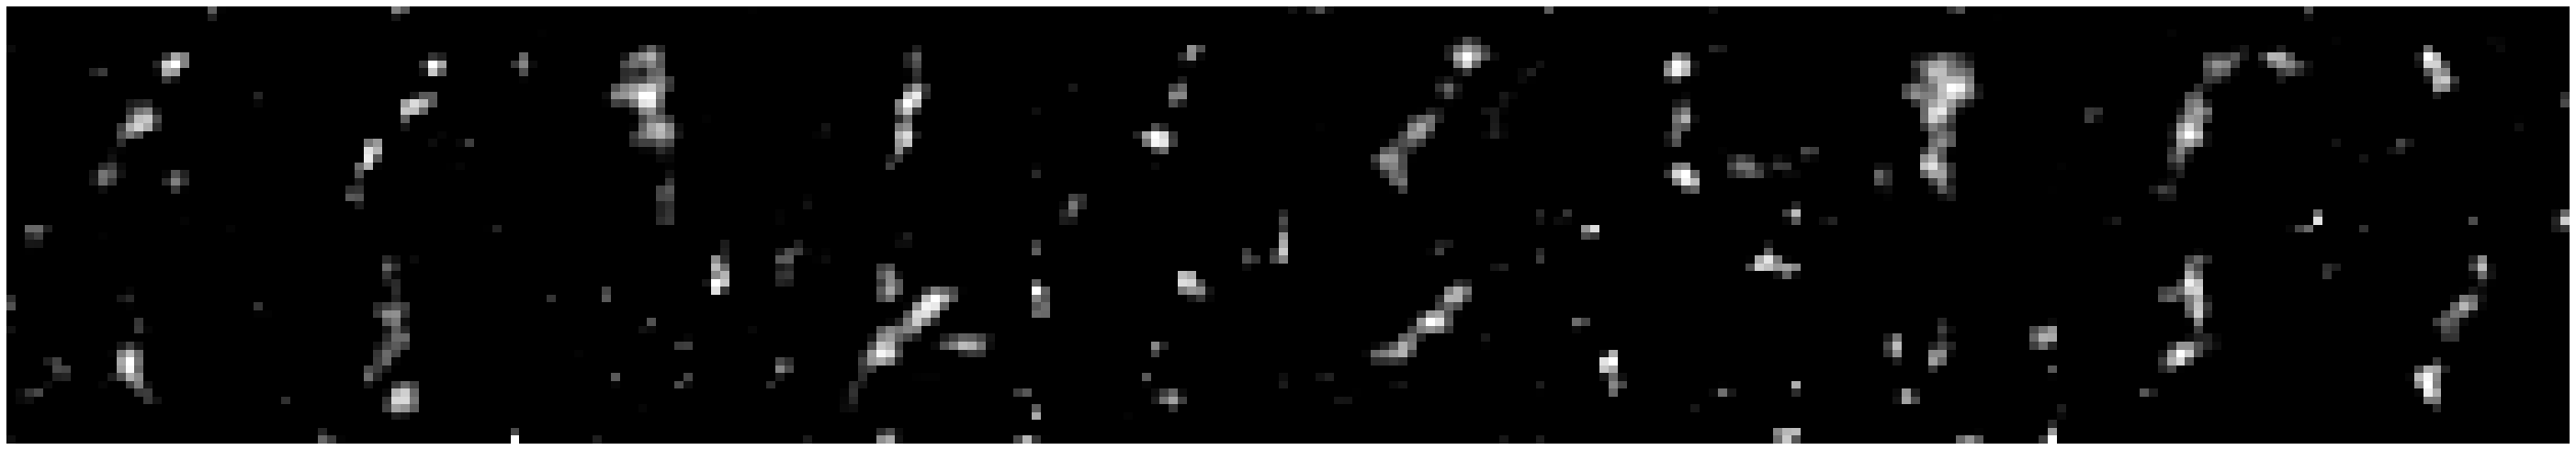

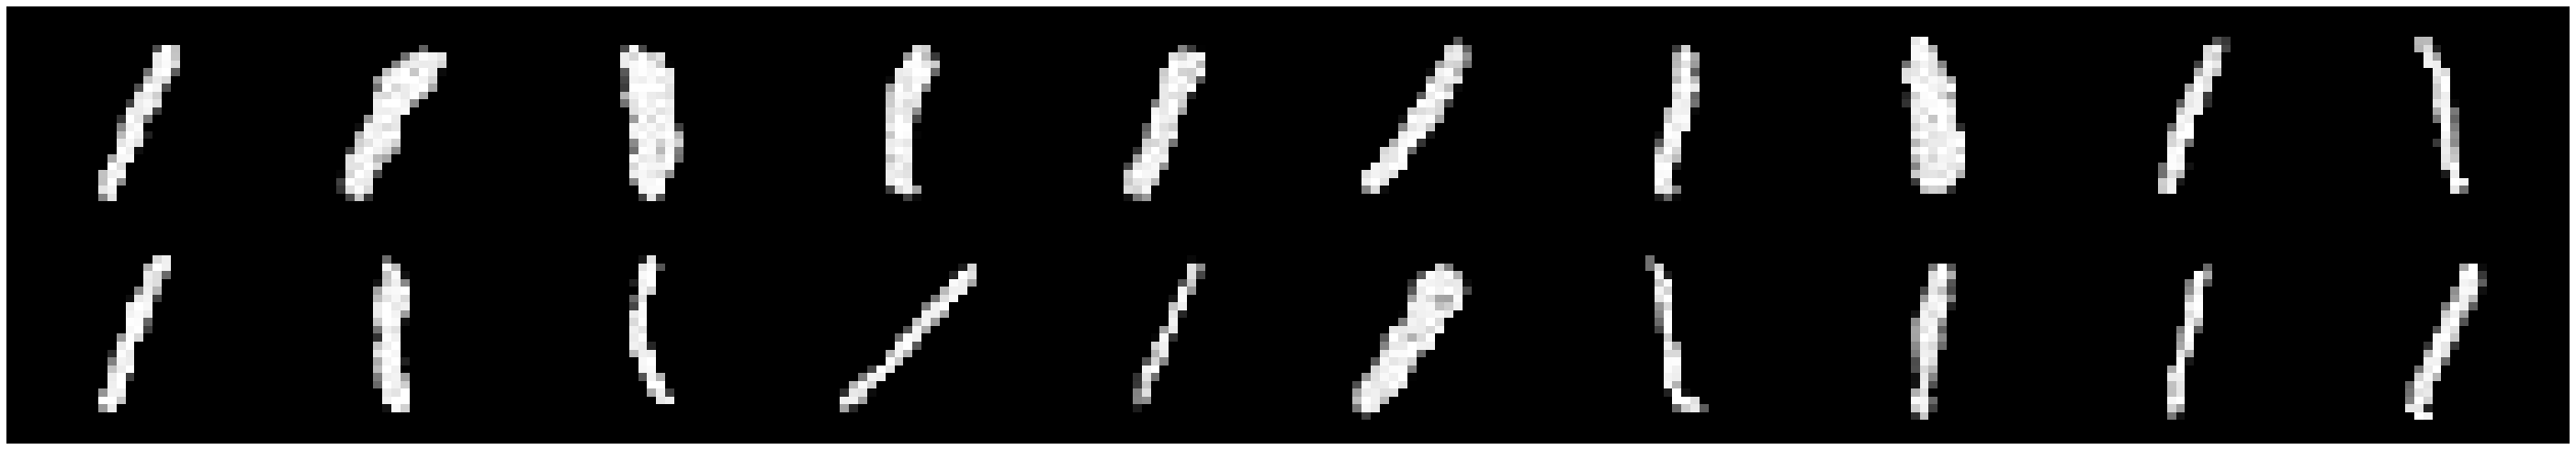

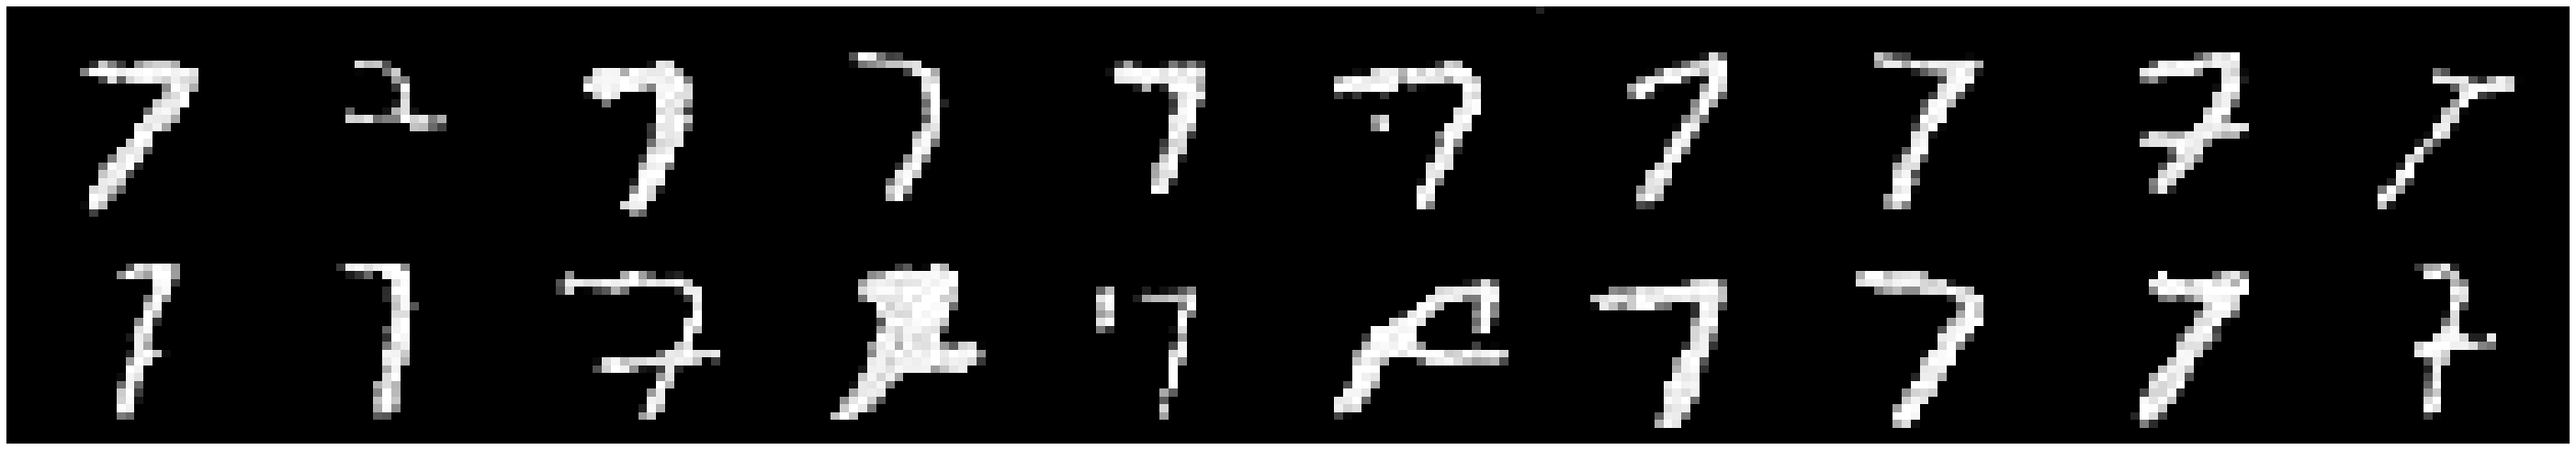

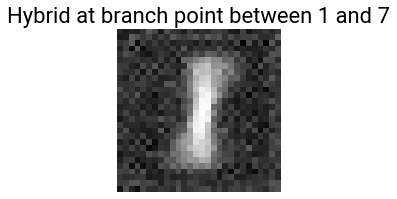

Branch point between 3 and 5


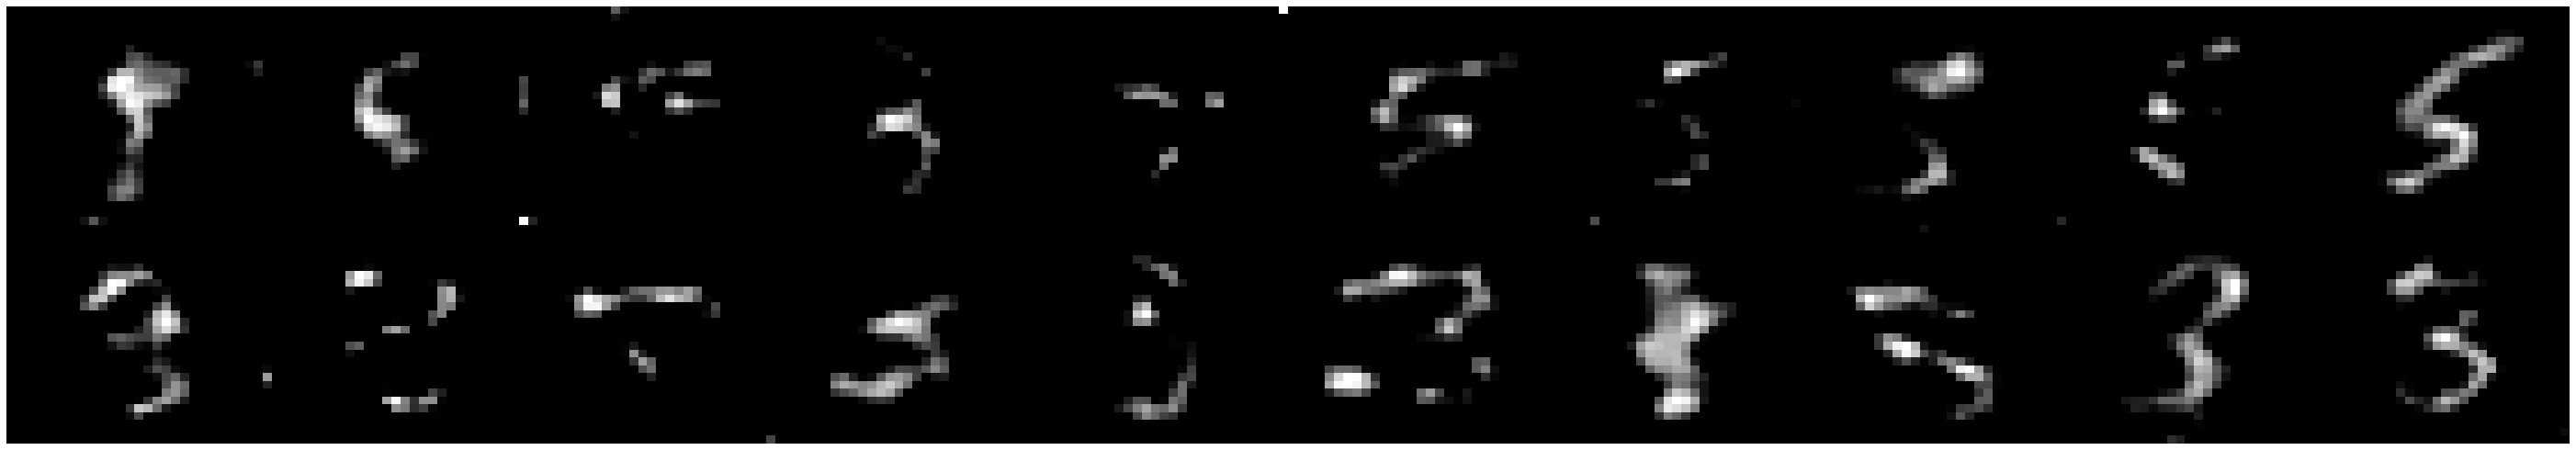

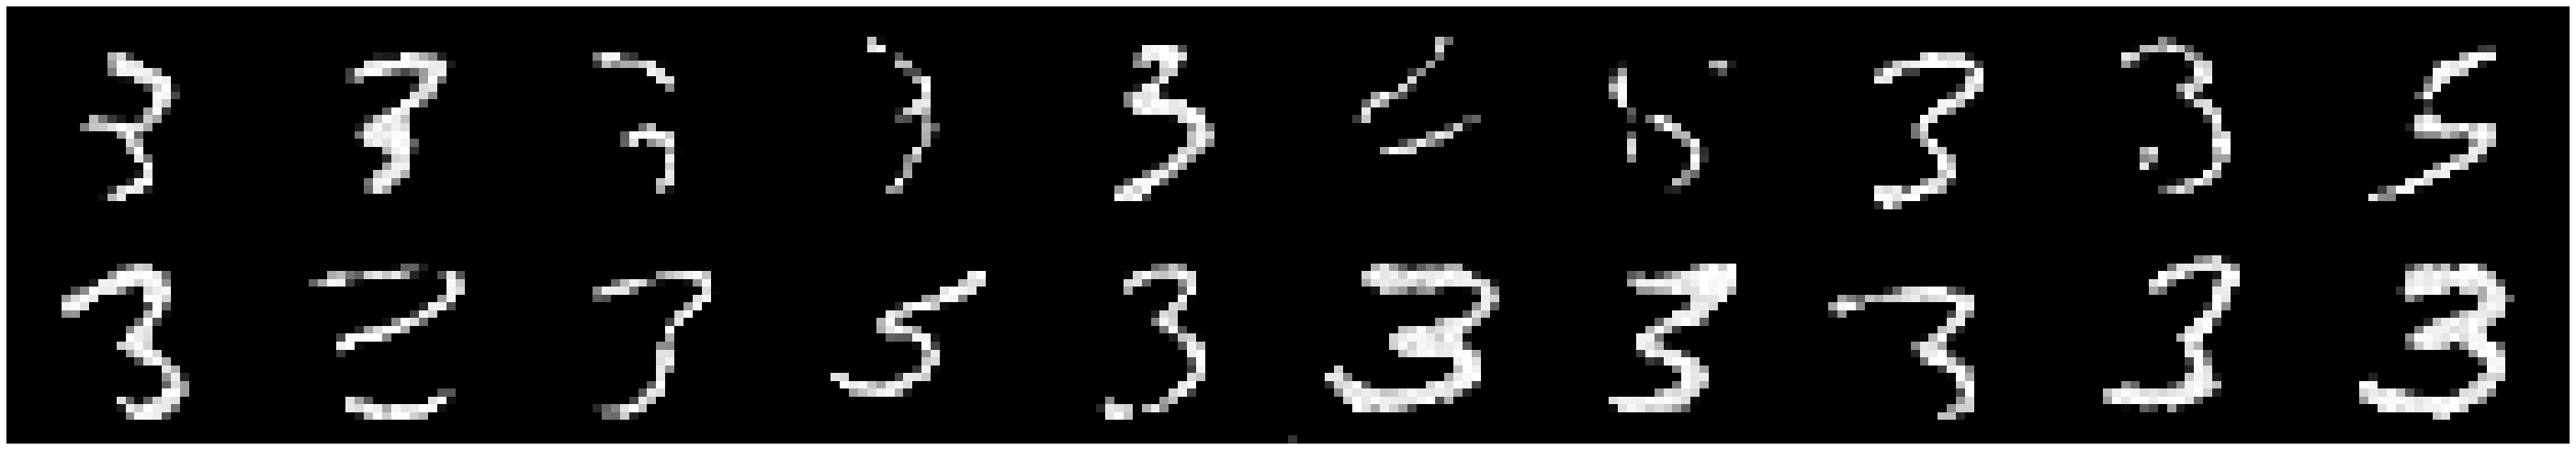

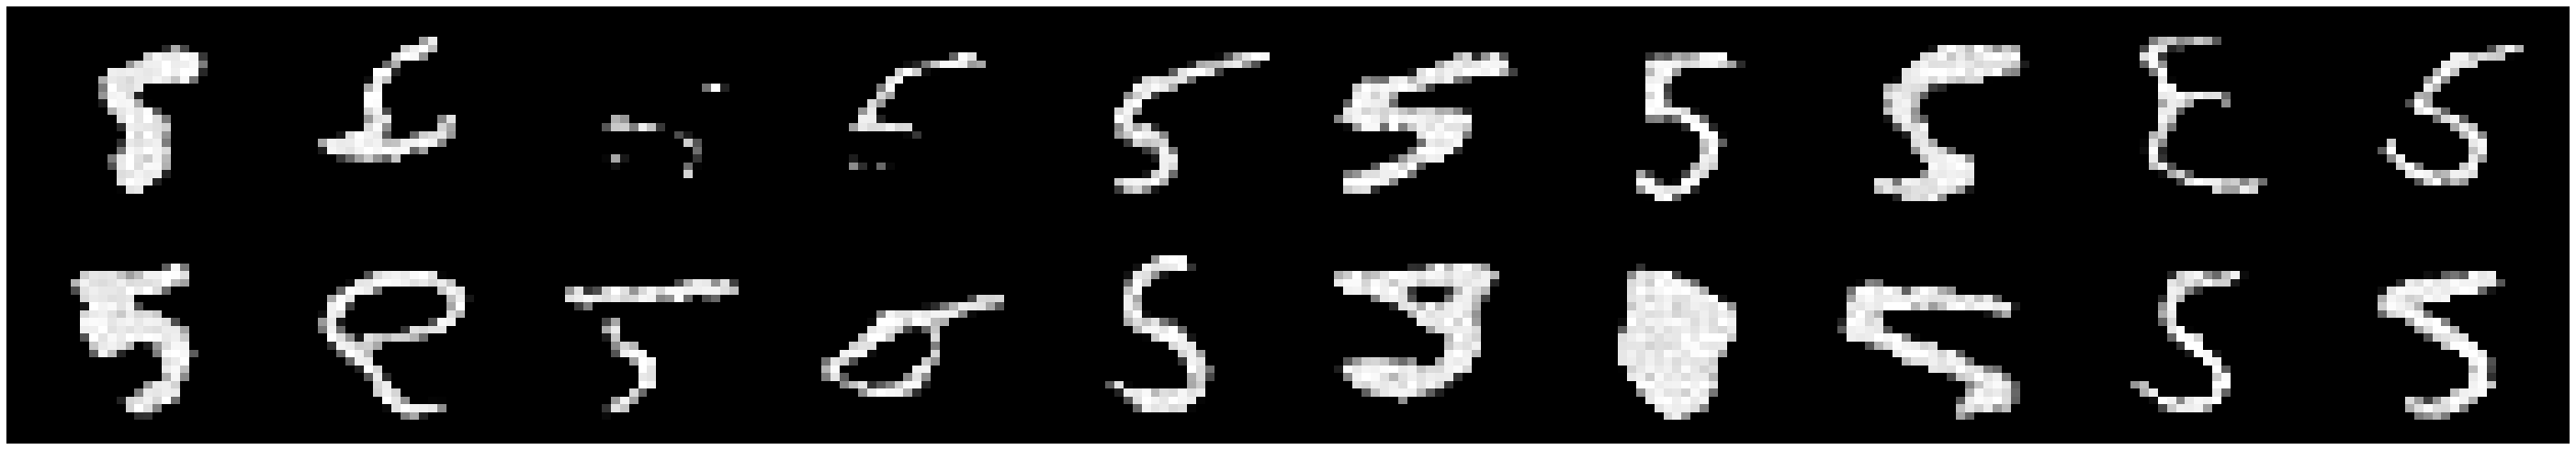

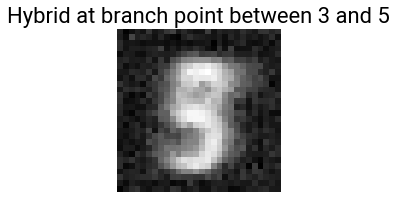

In [12]:
for class_1, class_2, branch_time in branch_point_examples:
    print("Branch point between %d and %d" % (class_1, class_2))
    samples_12 = generate.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor, sampler="pc", t_start=branch_time,
        t_limit=t_limit, num_samples=500
    ).cpu().numpy()
    samples_1 = generate.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor, sampler="pc", t_limit=branch_time,
        initial_samples=torch.tensor(samples_12).to(DEVICE), num_samples=500
    ).cpu().numpy()
    samples_2 = generate.generate_continuous_branched_samples(
        model, sde, class_2, class_time_to_branch_tensor, sampler="pc", t_limit=branch_time,
        initial_samples=torch.tensor(samples_12).to(DEVICE), num_samples=500
    ).cpu().numpy()

    smoothed_samples_12 = np.empty_like(samples_12)
    for i in range(len(samples_12)):
        smoothed_samples_12[i, 0] = scipy.ndimage.gaussian_filter(samples_12[i, 0], sigma=1)

    fig = plot_mnist_digits(smoothed_samples_12, grid_size=(10, 2), scale=5)
#     fig.savefig(
#         os.path.join(out_path, "mnist_hybrid_%d_%d.svg" % (class_1, class_2)),
#         format="svg"
#     )
    fig = plot_mnist_digits(samples_1, grid_size=(10, 2), scale=5)
#     fig.savefig(
#         os.path.join(out_path, "mnist_hybrid_%d.svg" % class_1),
#         format="svg"
#     )
    fig = plot_mnist_digits(samples_2, grid_size=(10, 2), scale=5)
#     fig.savefig(
#         os.path.join(out_path, "mnist_hybrid_%d.svg" % class_2),
#         format="svg"
#     )
    
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(np.mean(samples_12, axis=(0, 1)), cmap="Greys_r")
    ax.axis("off")
    ax.set_title("Hybrid at branch point between %d and %d" % (class_1, class_2))
    fig.savefig(
        os.path.join(out_path, "mnist_hybrid_average_%d_%d.svg" % (class_1, class_2)),
        format="svg"
    )
    plt.show()

### Transmutation

In [13]:
def binarize(x):
    mask = x > 0
    new_x = x.copy()
    new_x[mask] = 1
    new_x[~mask] = 0
    return new_x

def get_main_slope(image, plot=False):
    """
    Given a NumPy-array image of shape H x W, gives the slope (m) of the
    most supported line found by the Hough transform.
    """
    image = binarize(image)
    acc, thetas, rhos = skimage.transform.hough_line(image)
    votes, angles, dists = skimage.transform.hough_line_peaks(
        acc, thetas, rhos, min_angle=30
    )
    slopes = -np.tan(angles + (np.pi / 2))
    # Take the negative here so that the slope matches our intuition when
    # we plot the image
    
    if not len(slopes):
        return 0  # Arbitrarily return 0
    
    if plot:
        fig, ax = plt.subplots(figsize=(2, 2))
        ax.imshow(image, cmap="gray")
        ax.set_ylim((image.shape[0], 0))
        ax.set_axis_off()
        colors = ["royalblue"] * len(slopes)
        colors[np.argmax(votes)] = "orangered"
        for i in range(len(slopes)):
            x, y = dists[i] * np.cos(angles[i]), dists[i] * np.sin(angles[i])
            ax.axline((x, y), slope=-slopes[i], color=colors[i])  # Use un-transformed slope
        plt.show()
    
    return slopes[np.argmax(votes)]

Class 4 to 9
Class 9 to 4
Class 1 to 7
Class 7 to 1
Class 3 to 5
Class 5 to 3


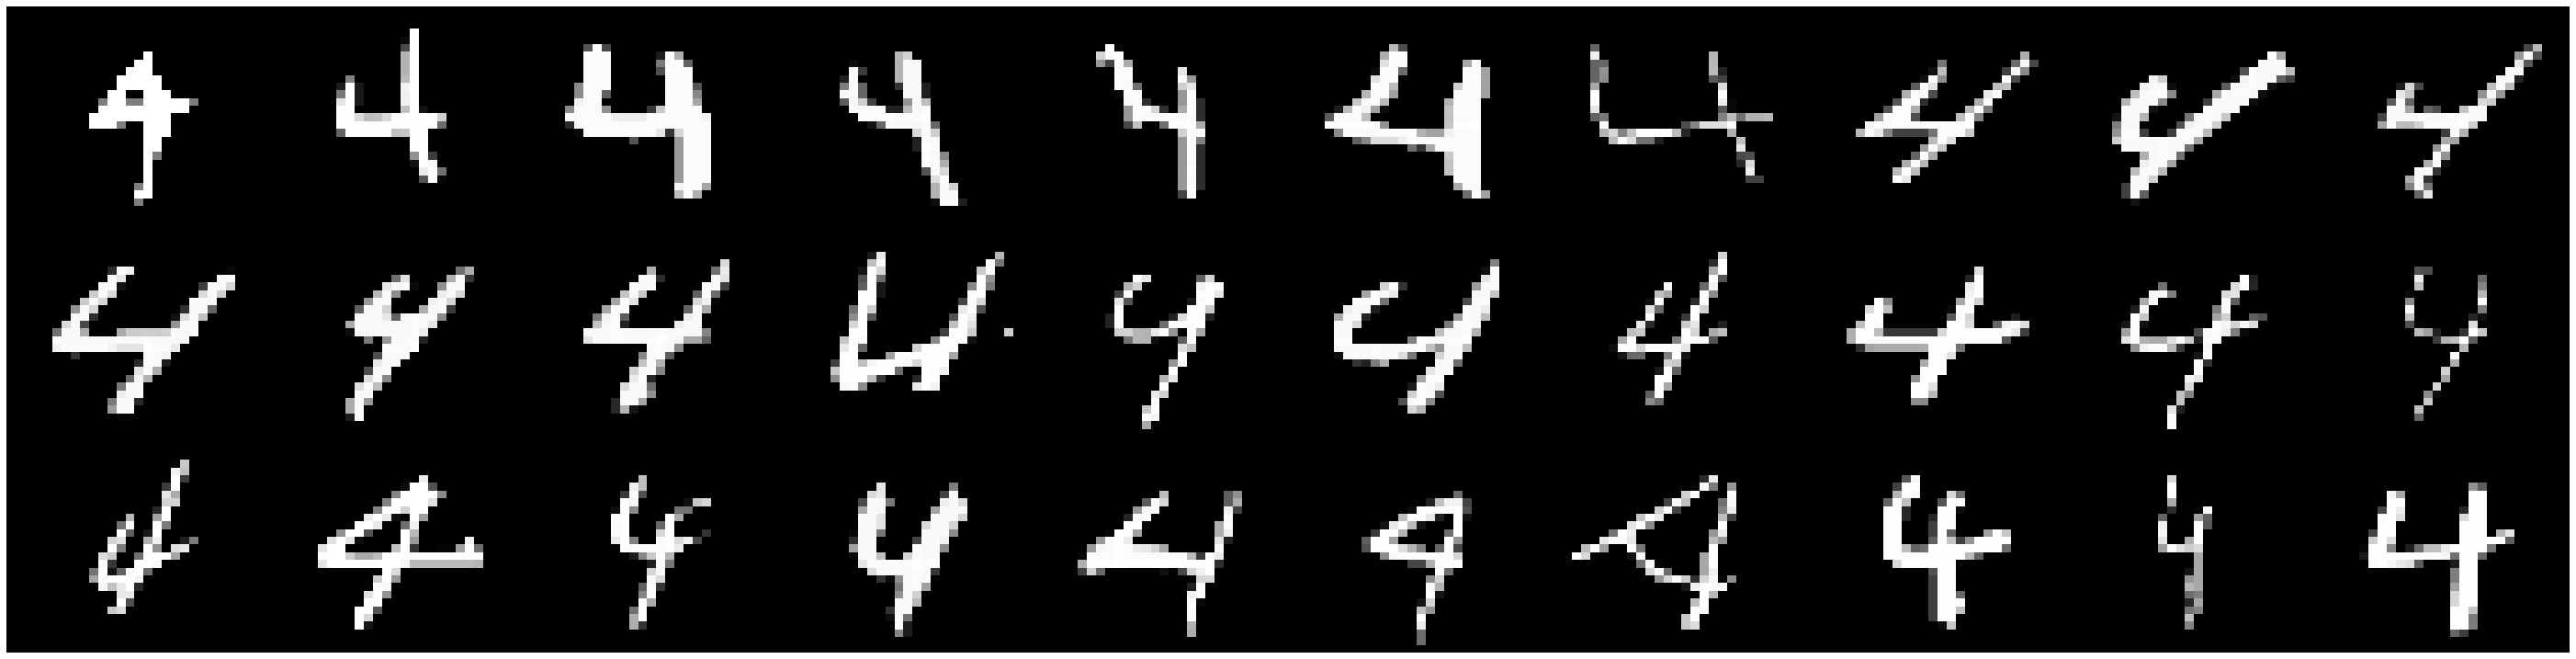

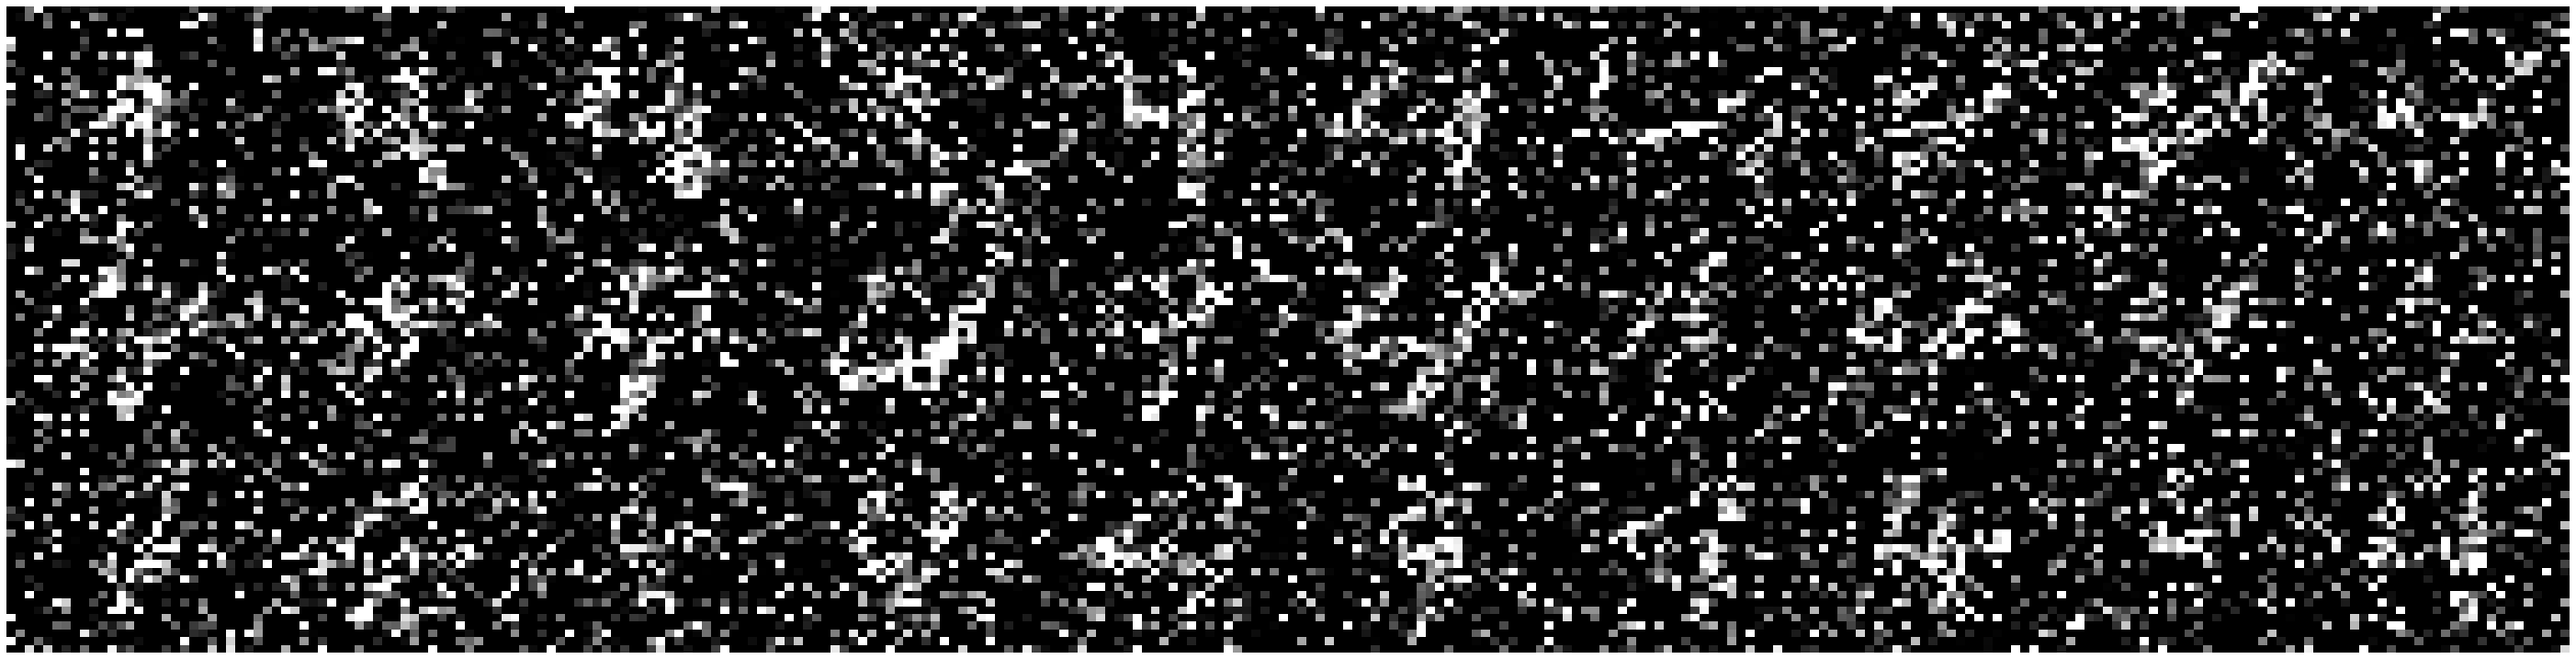

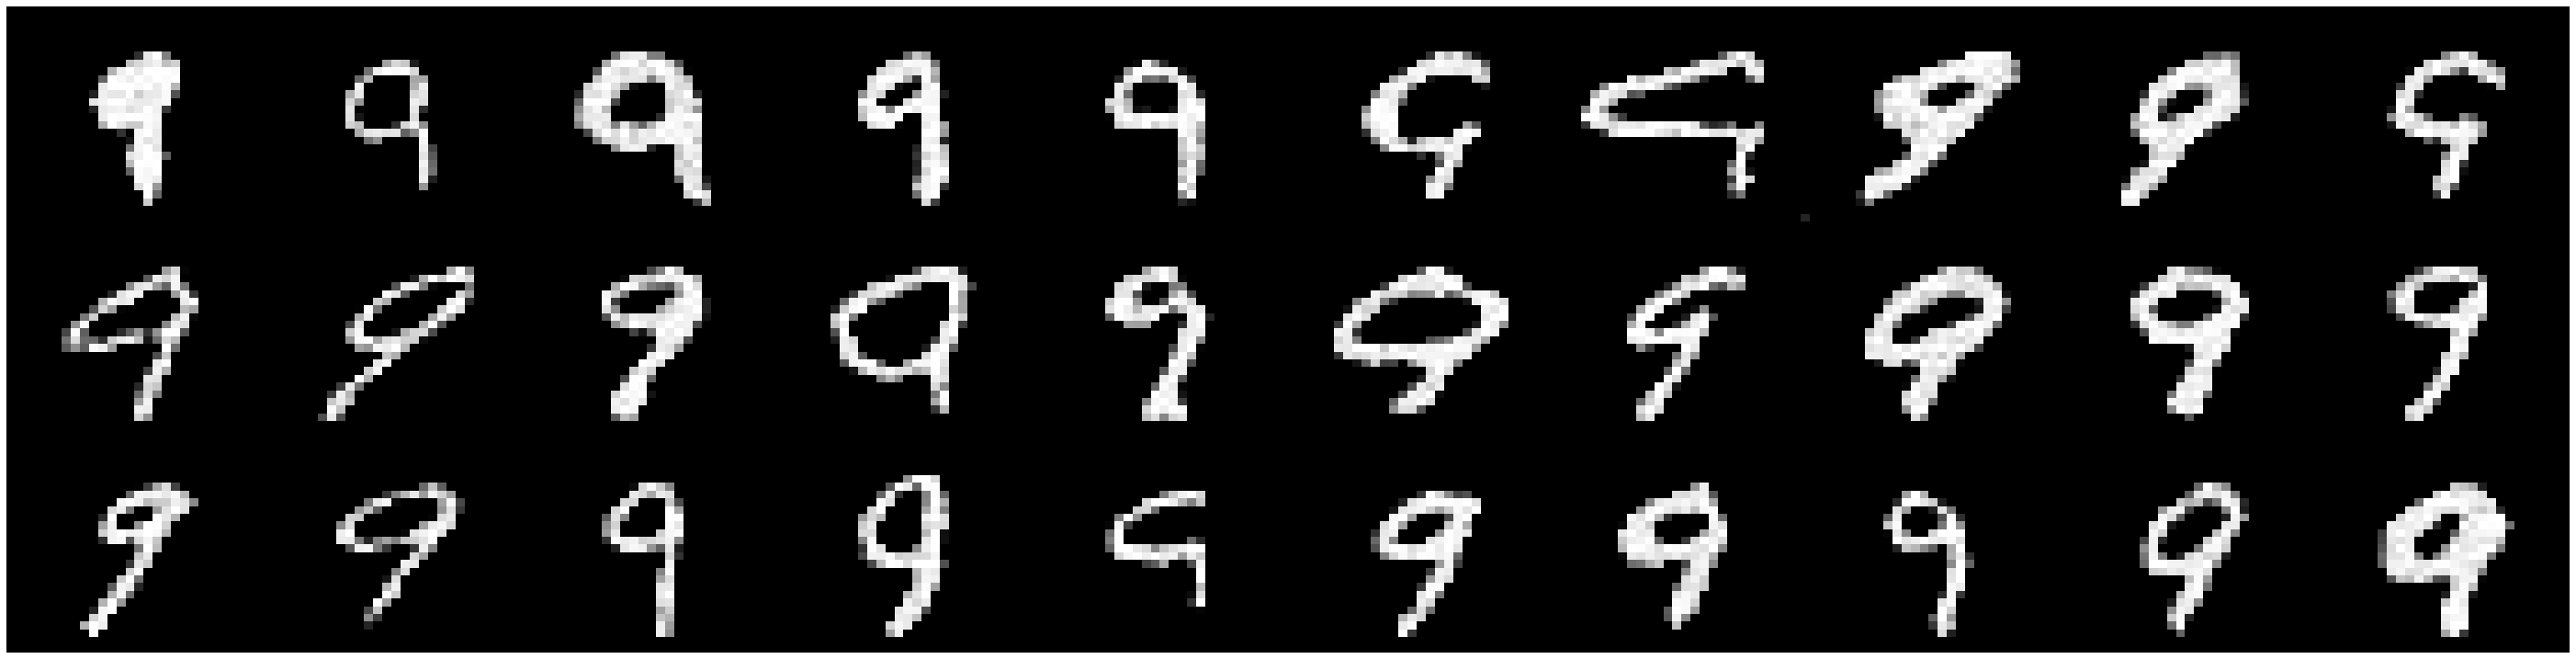

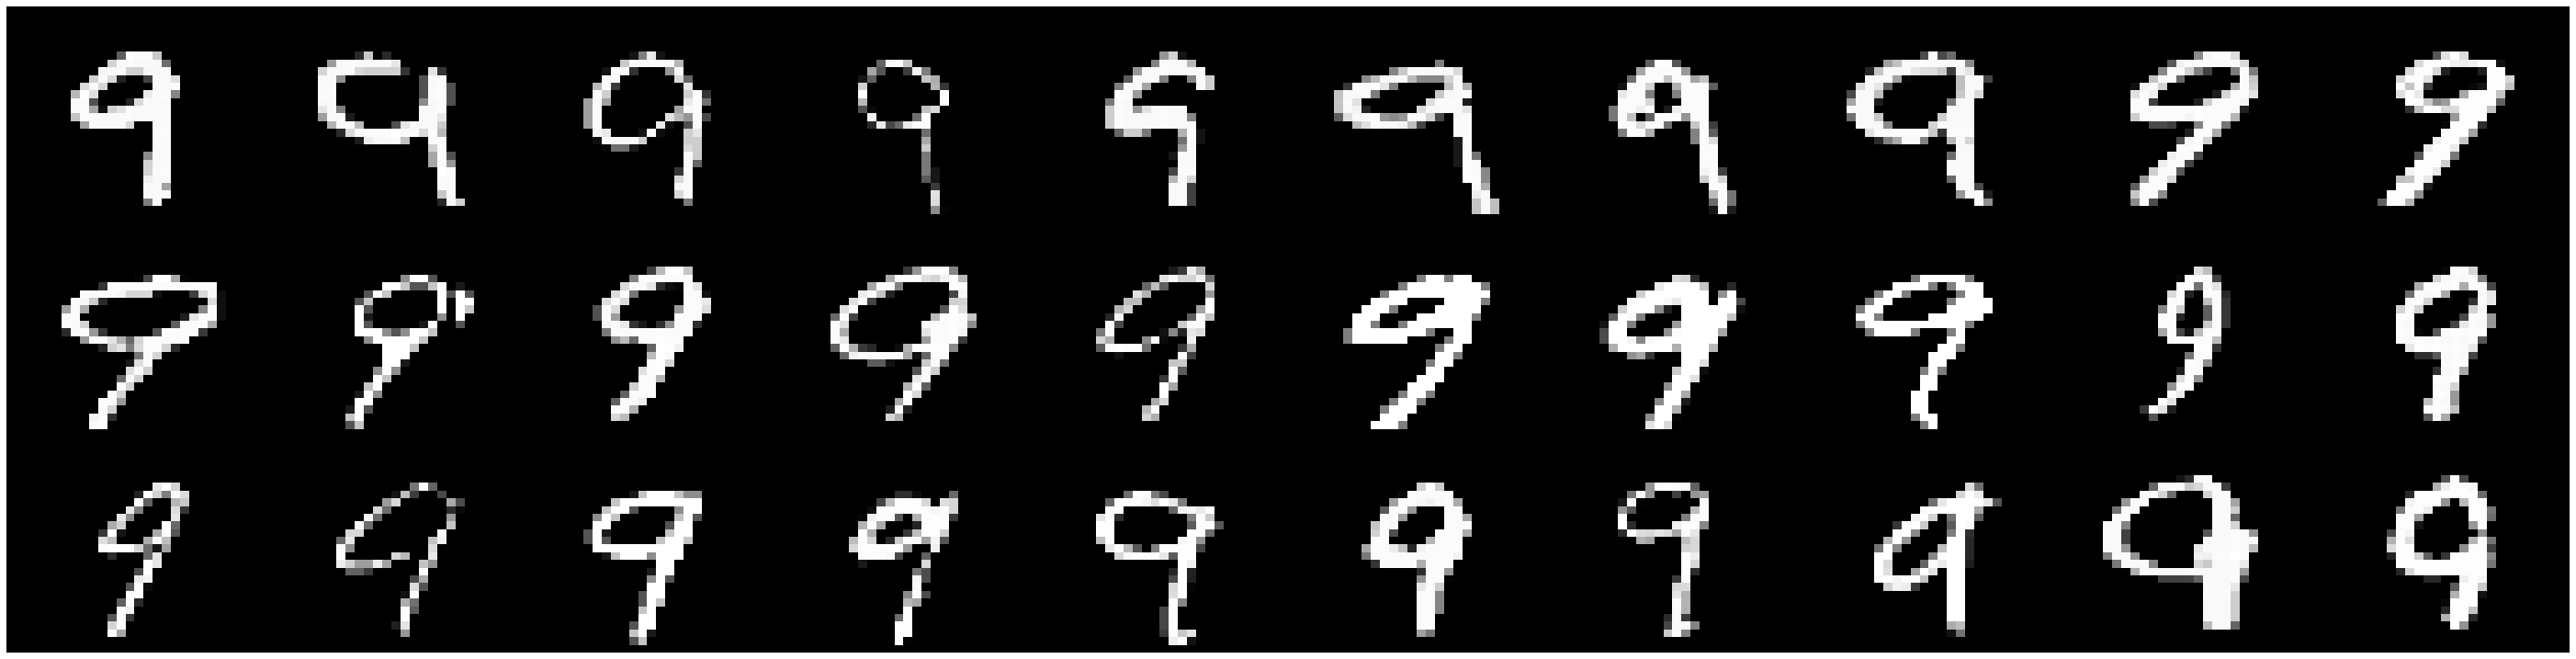

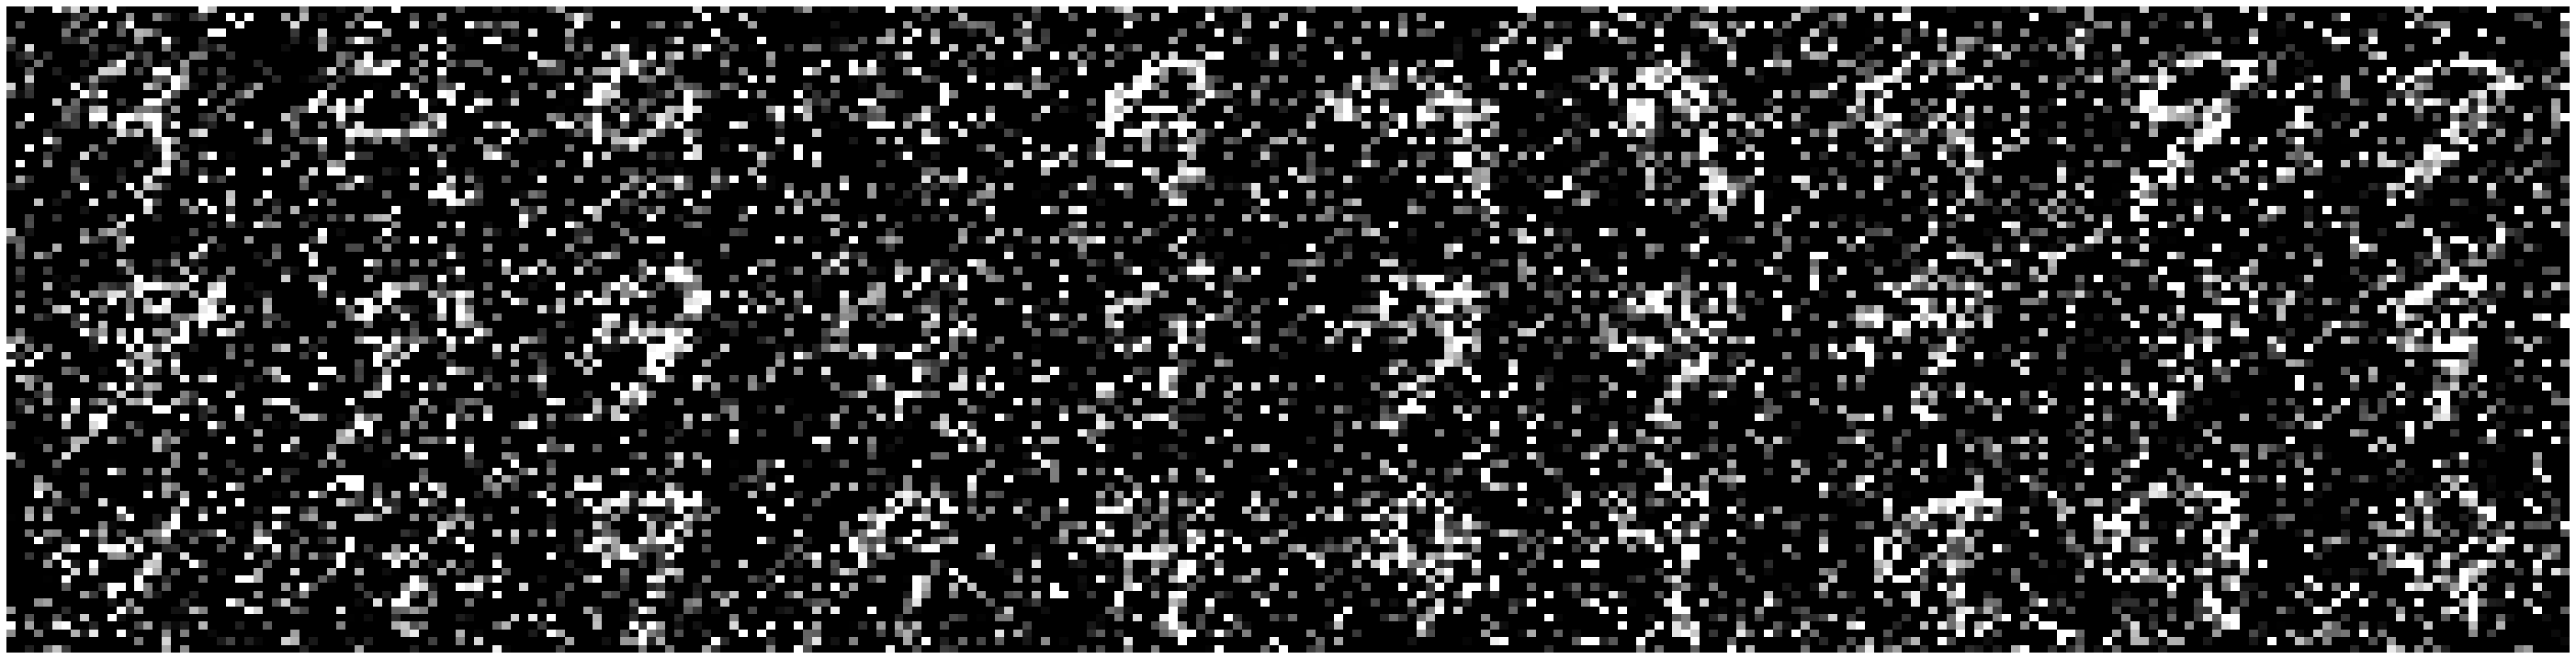

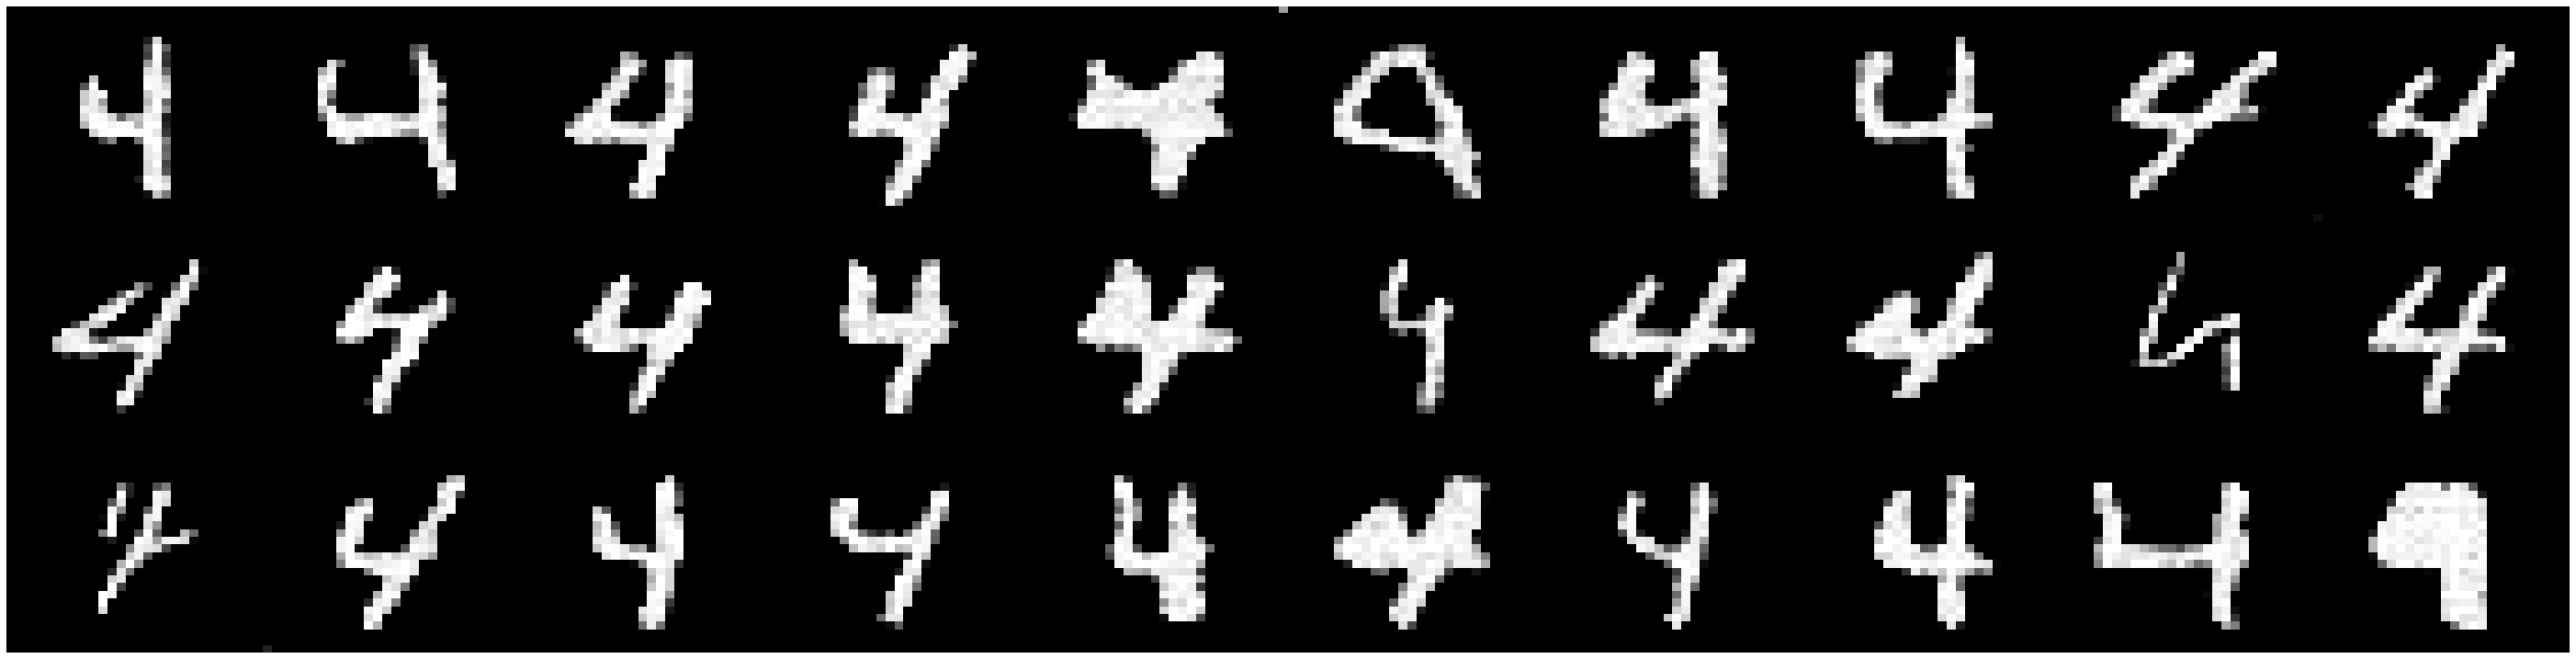

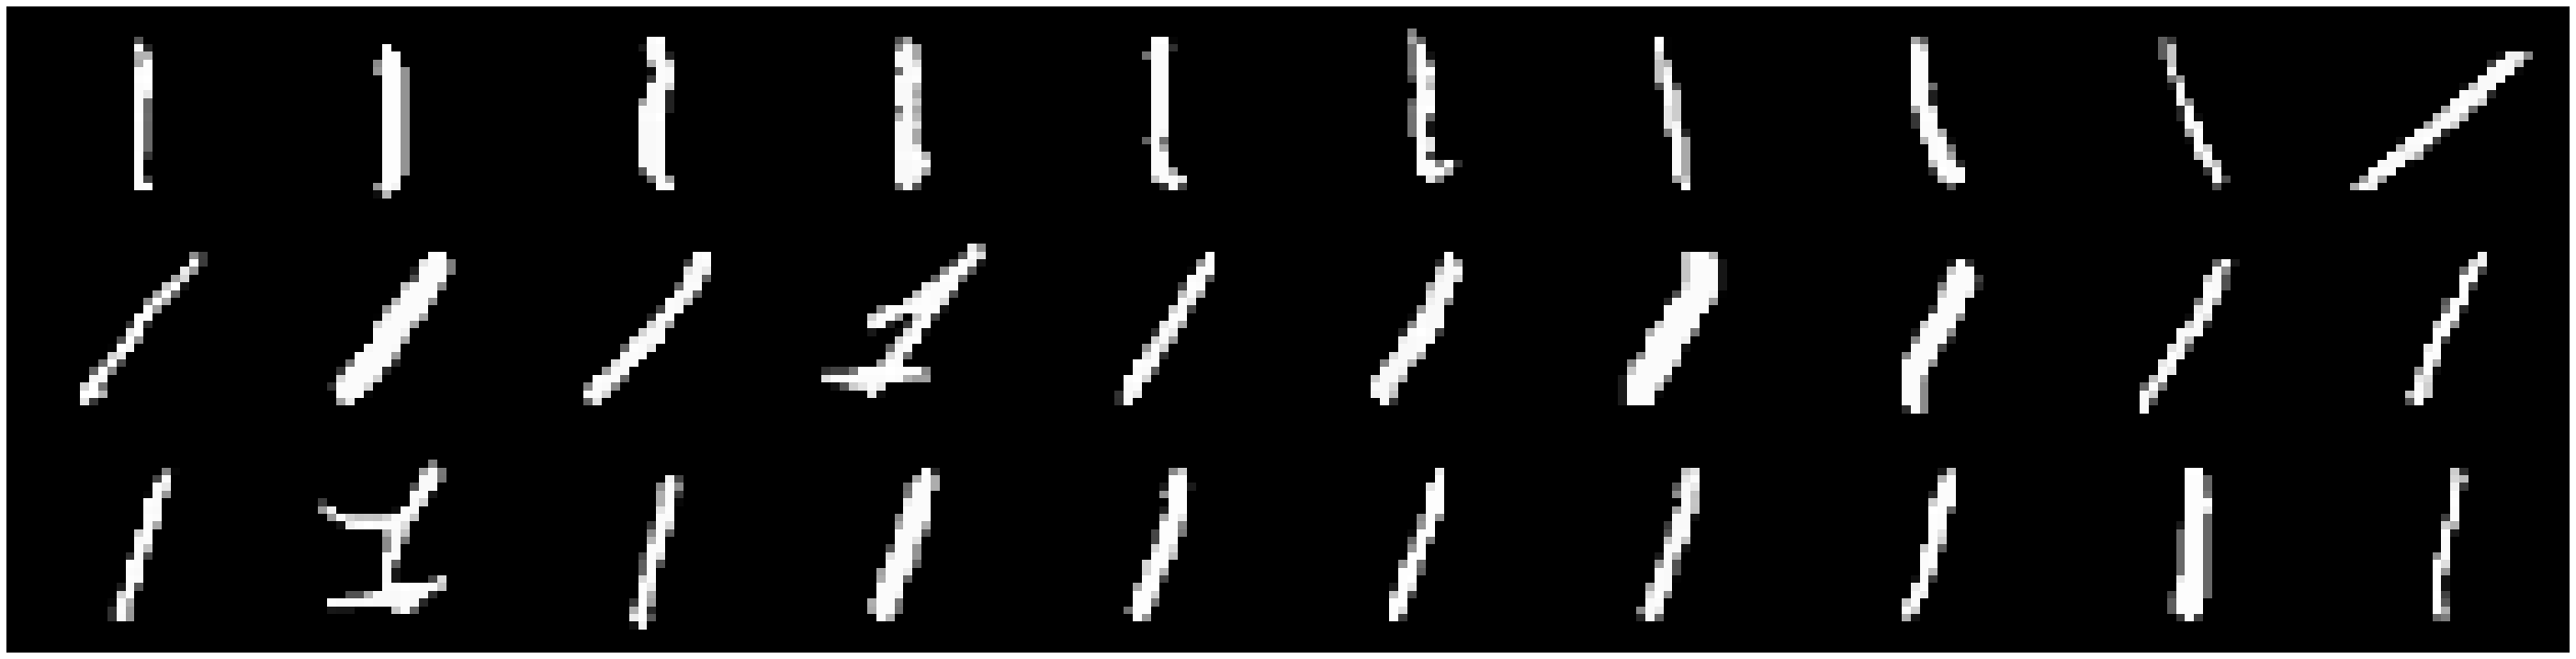

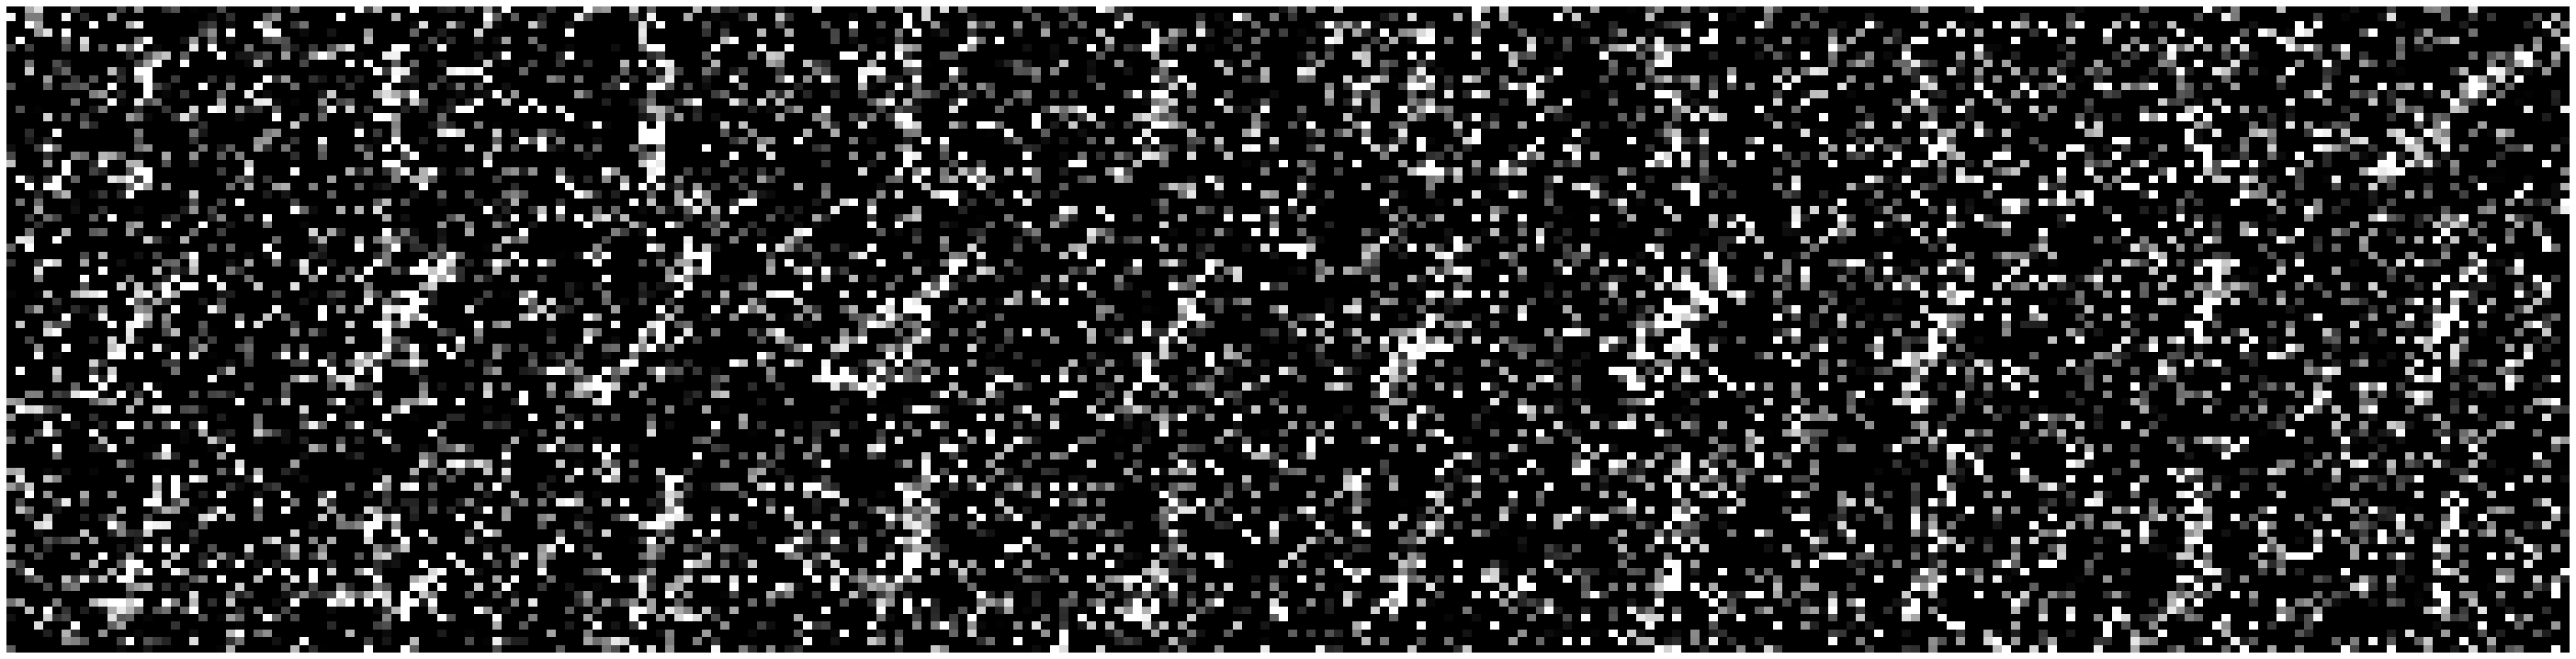

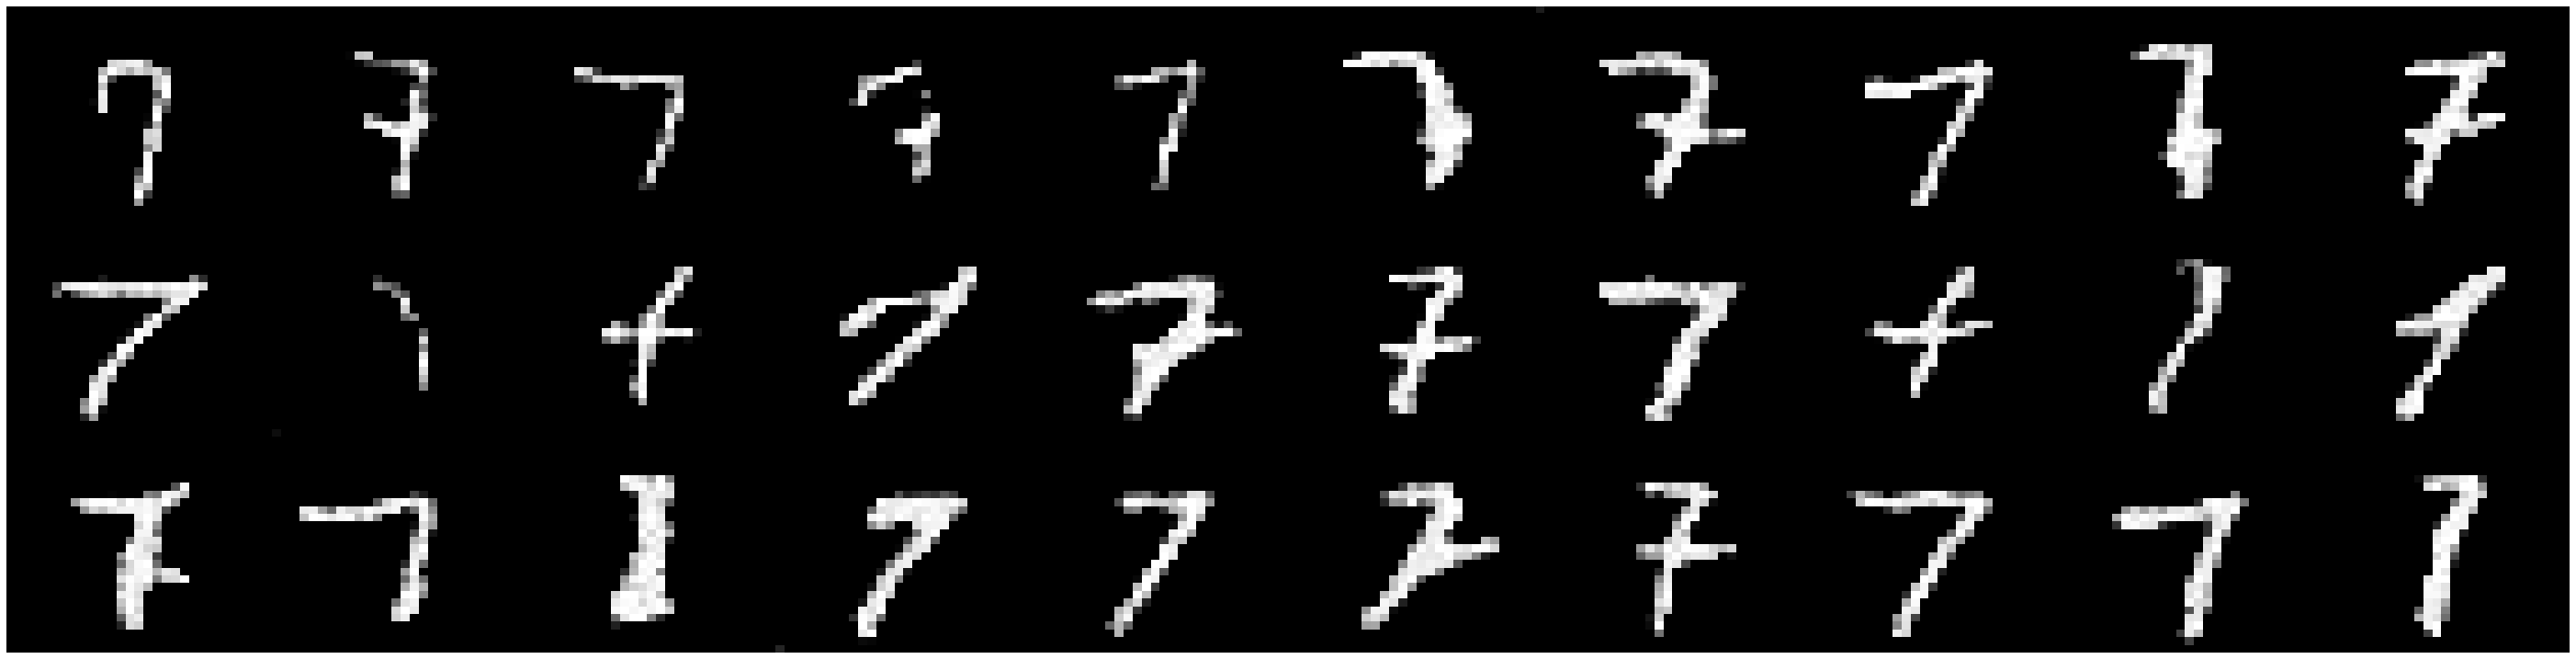

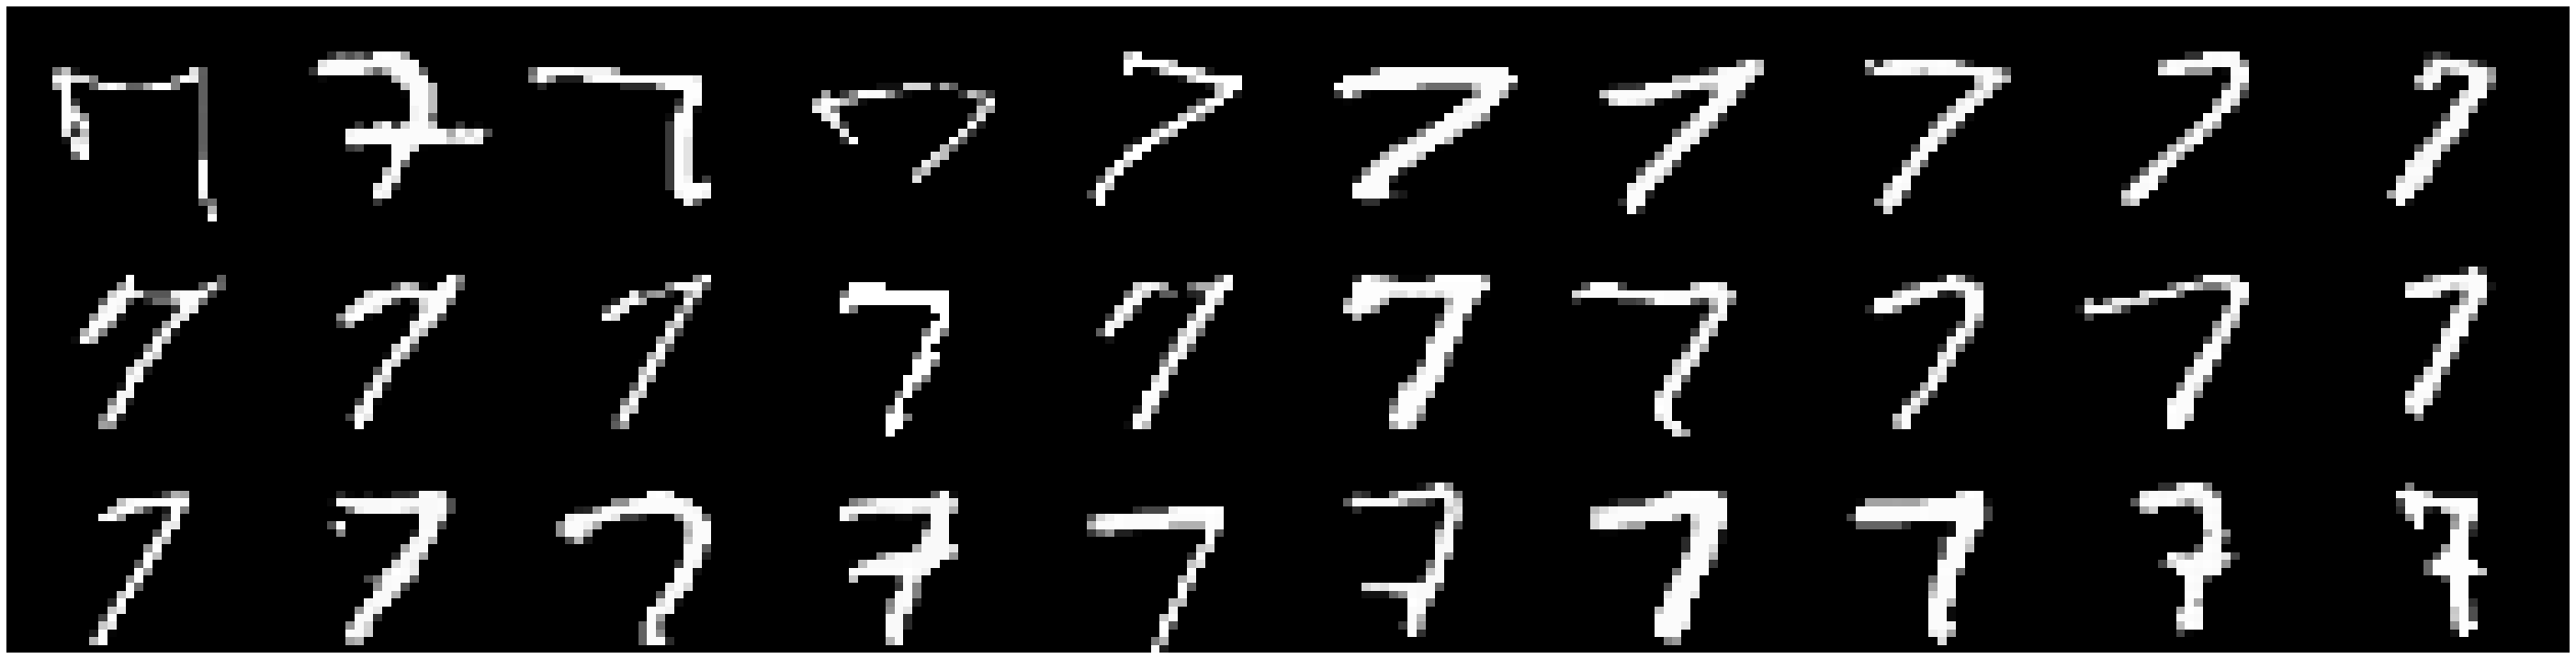

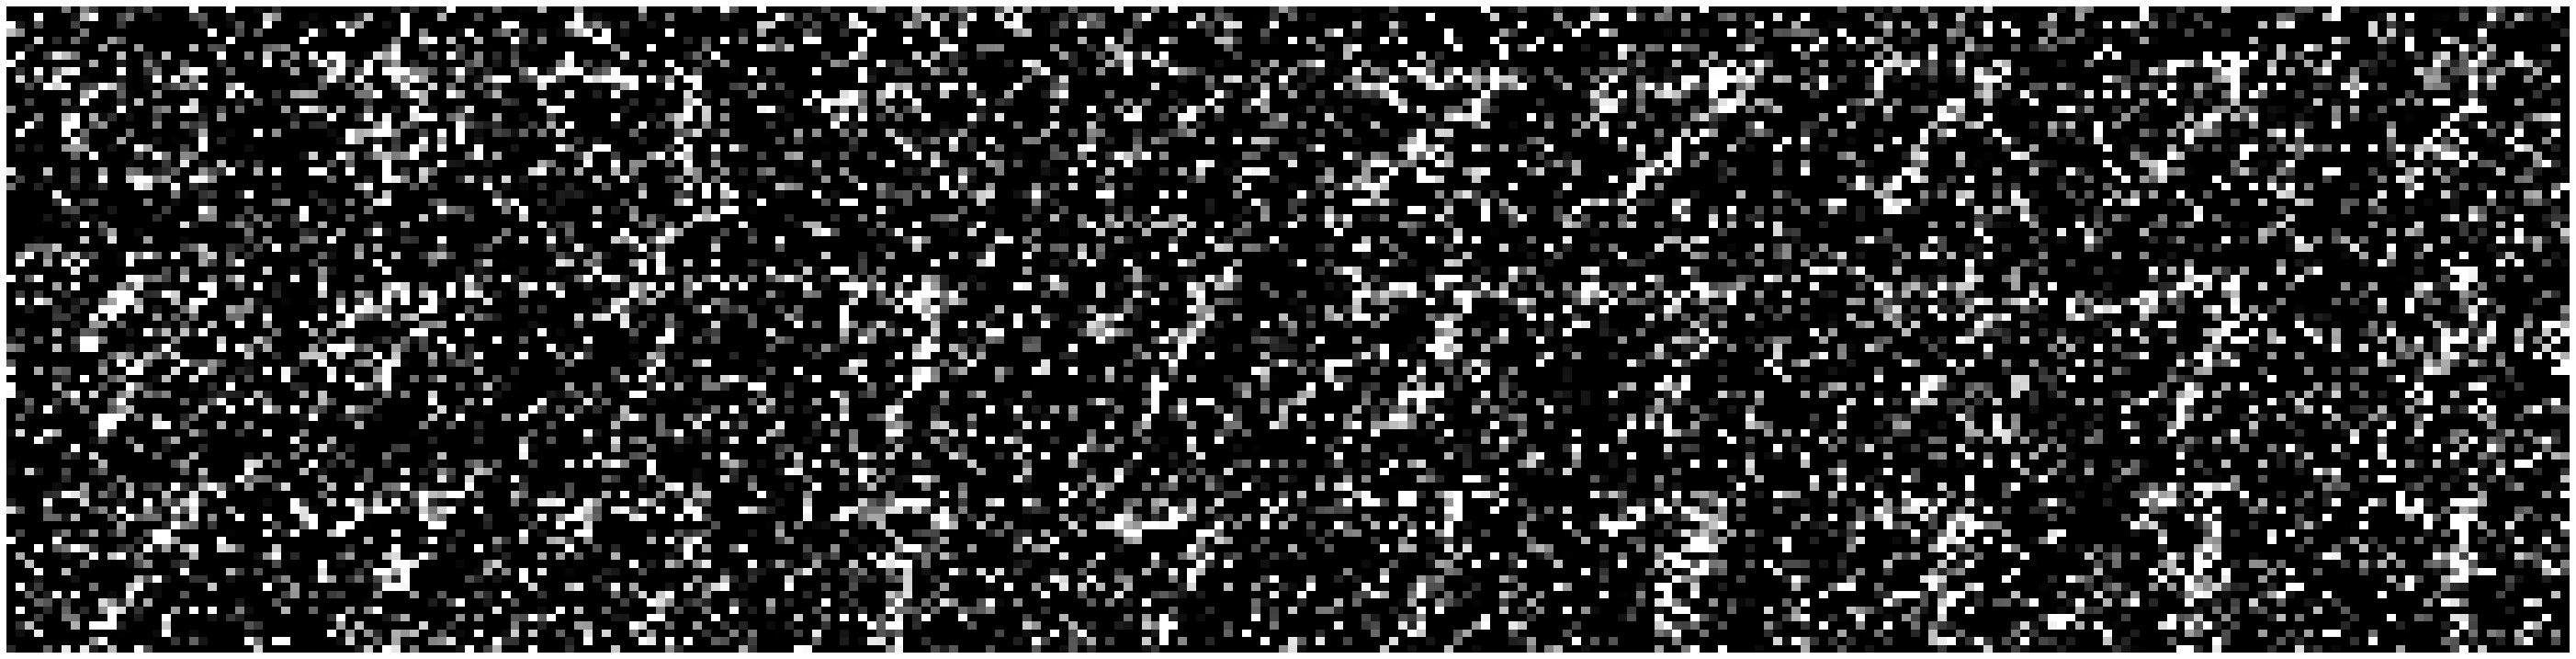

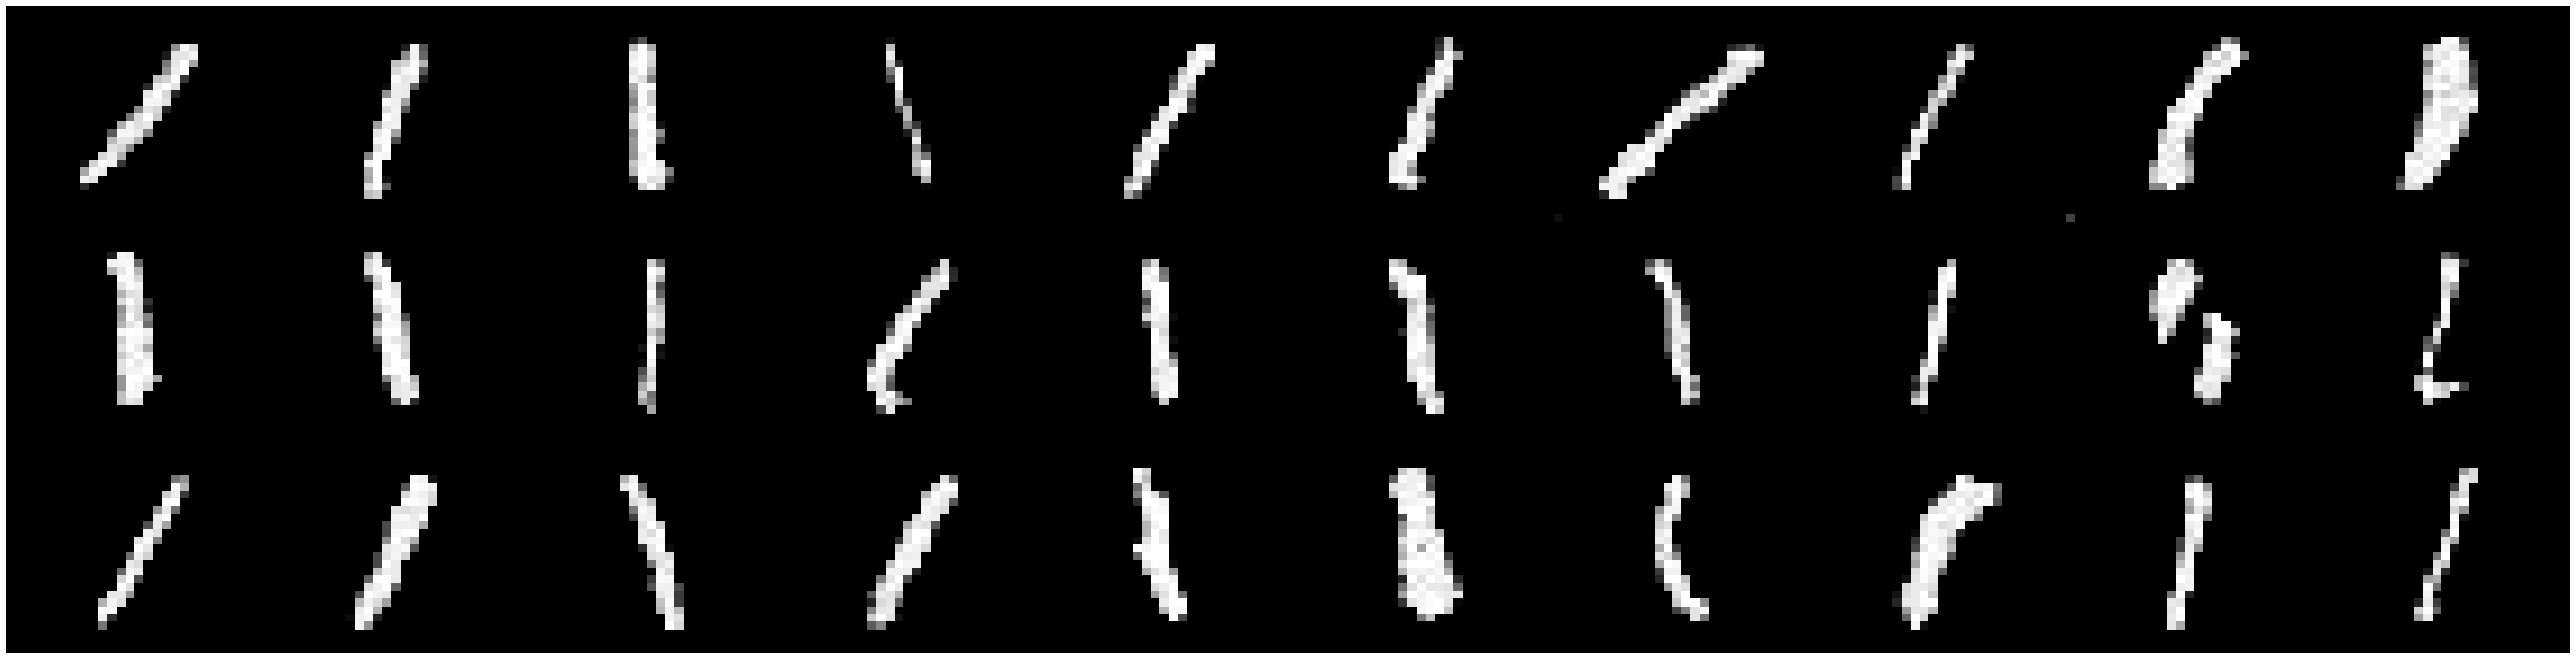

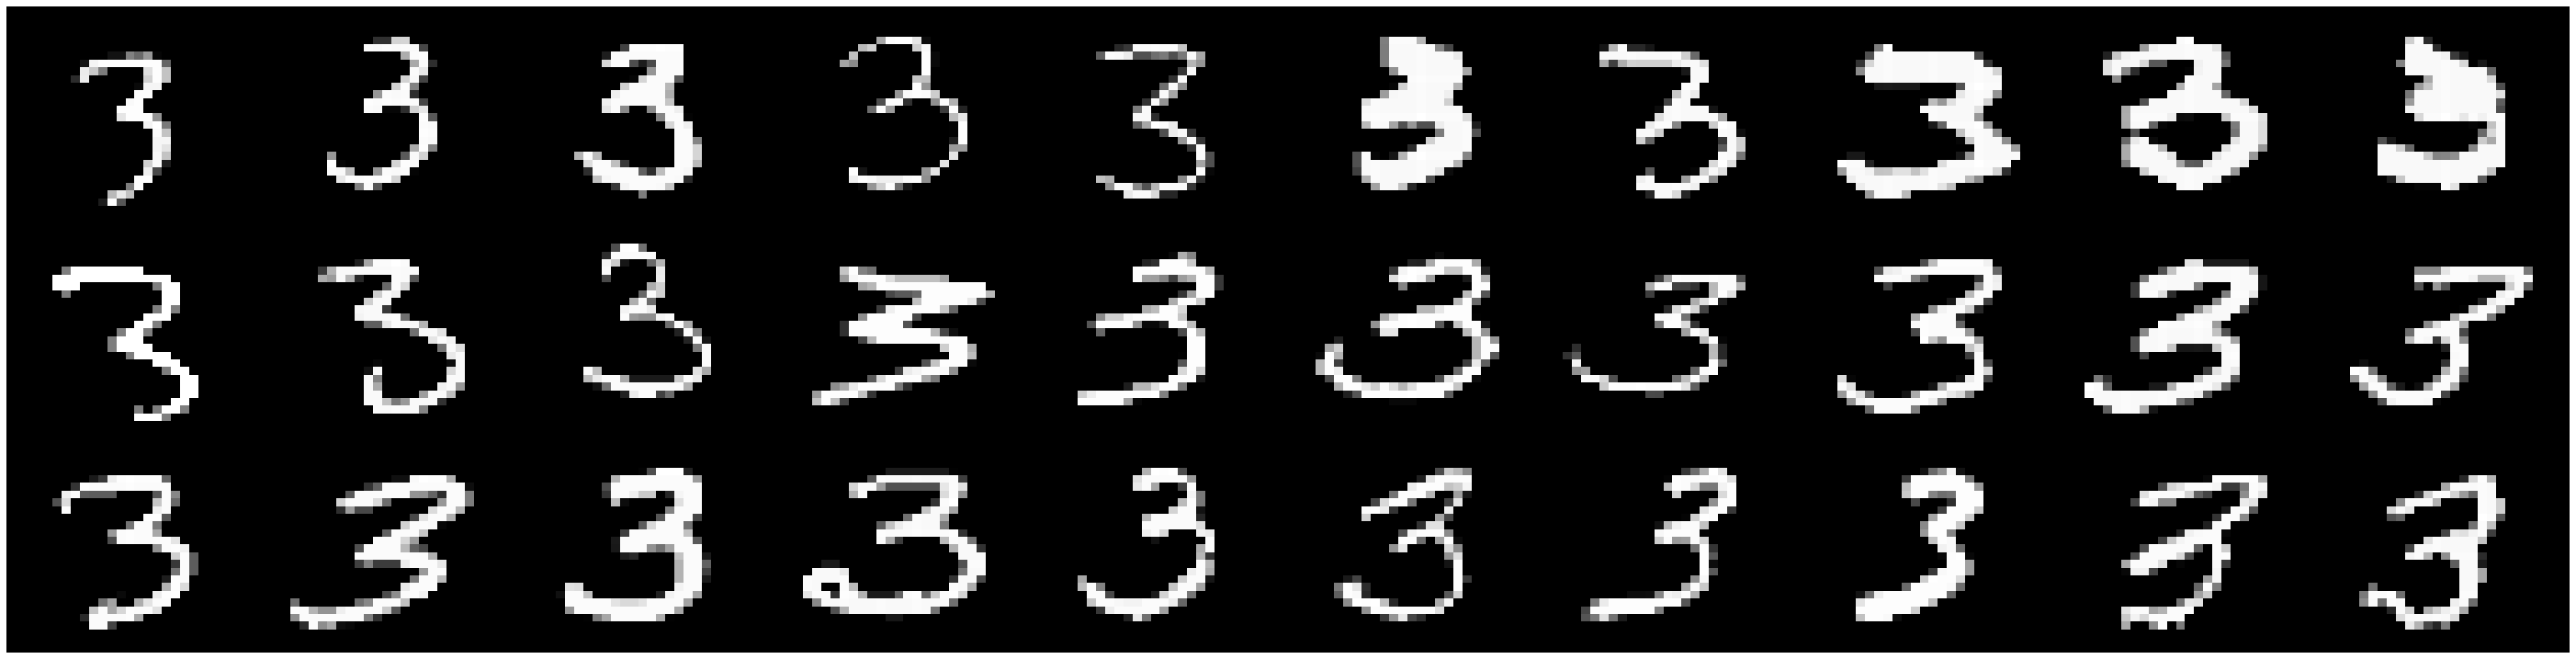

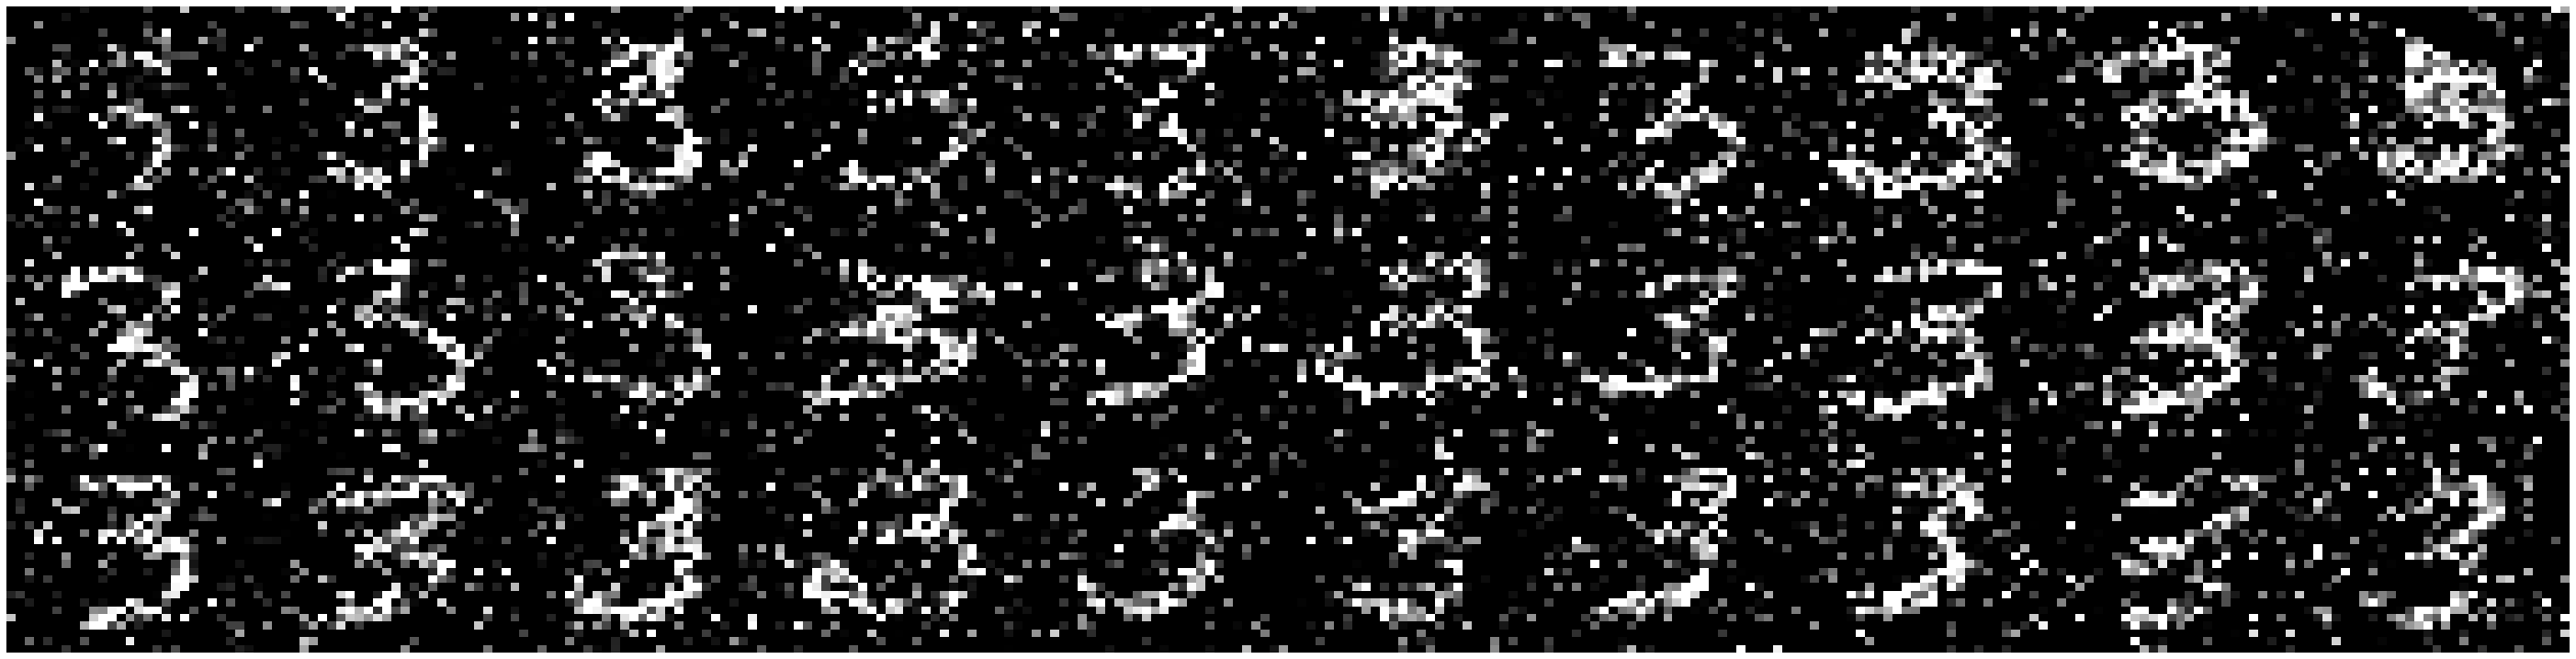

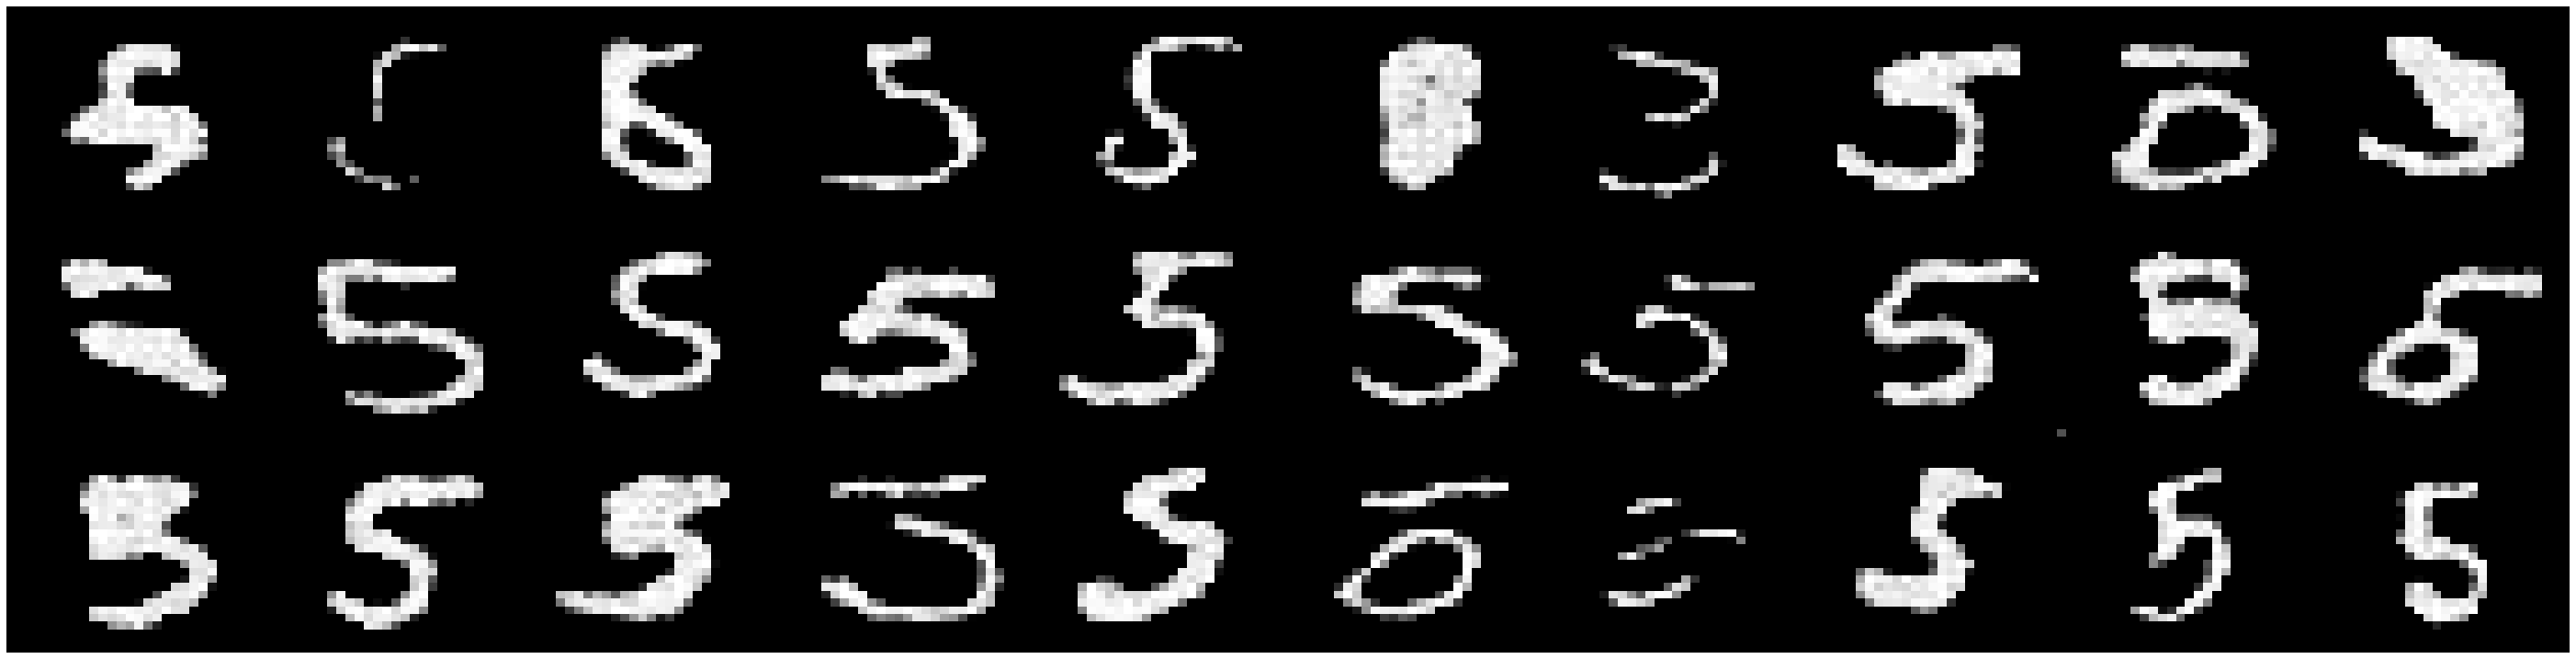

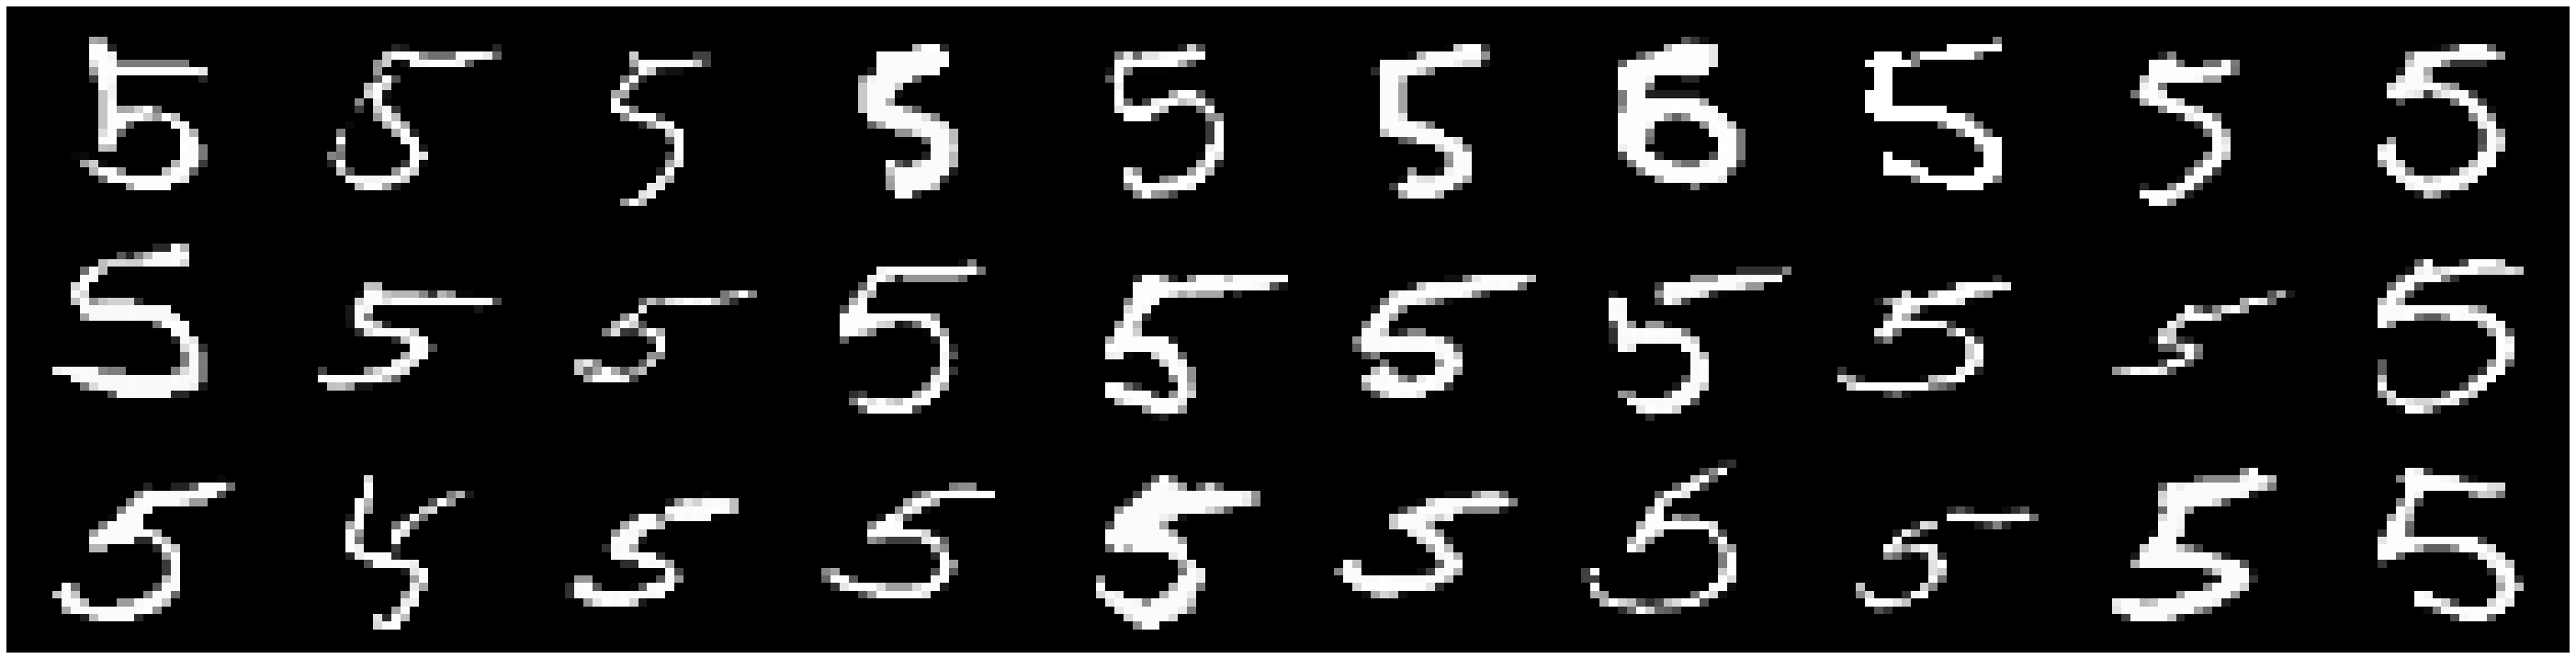

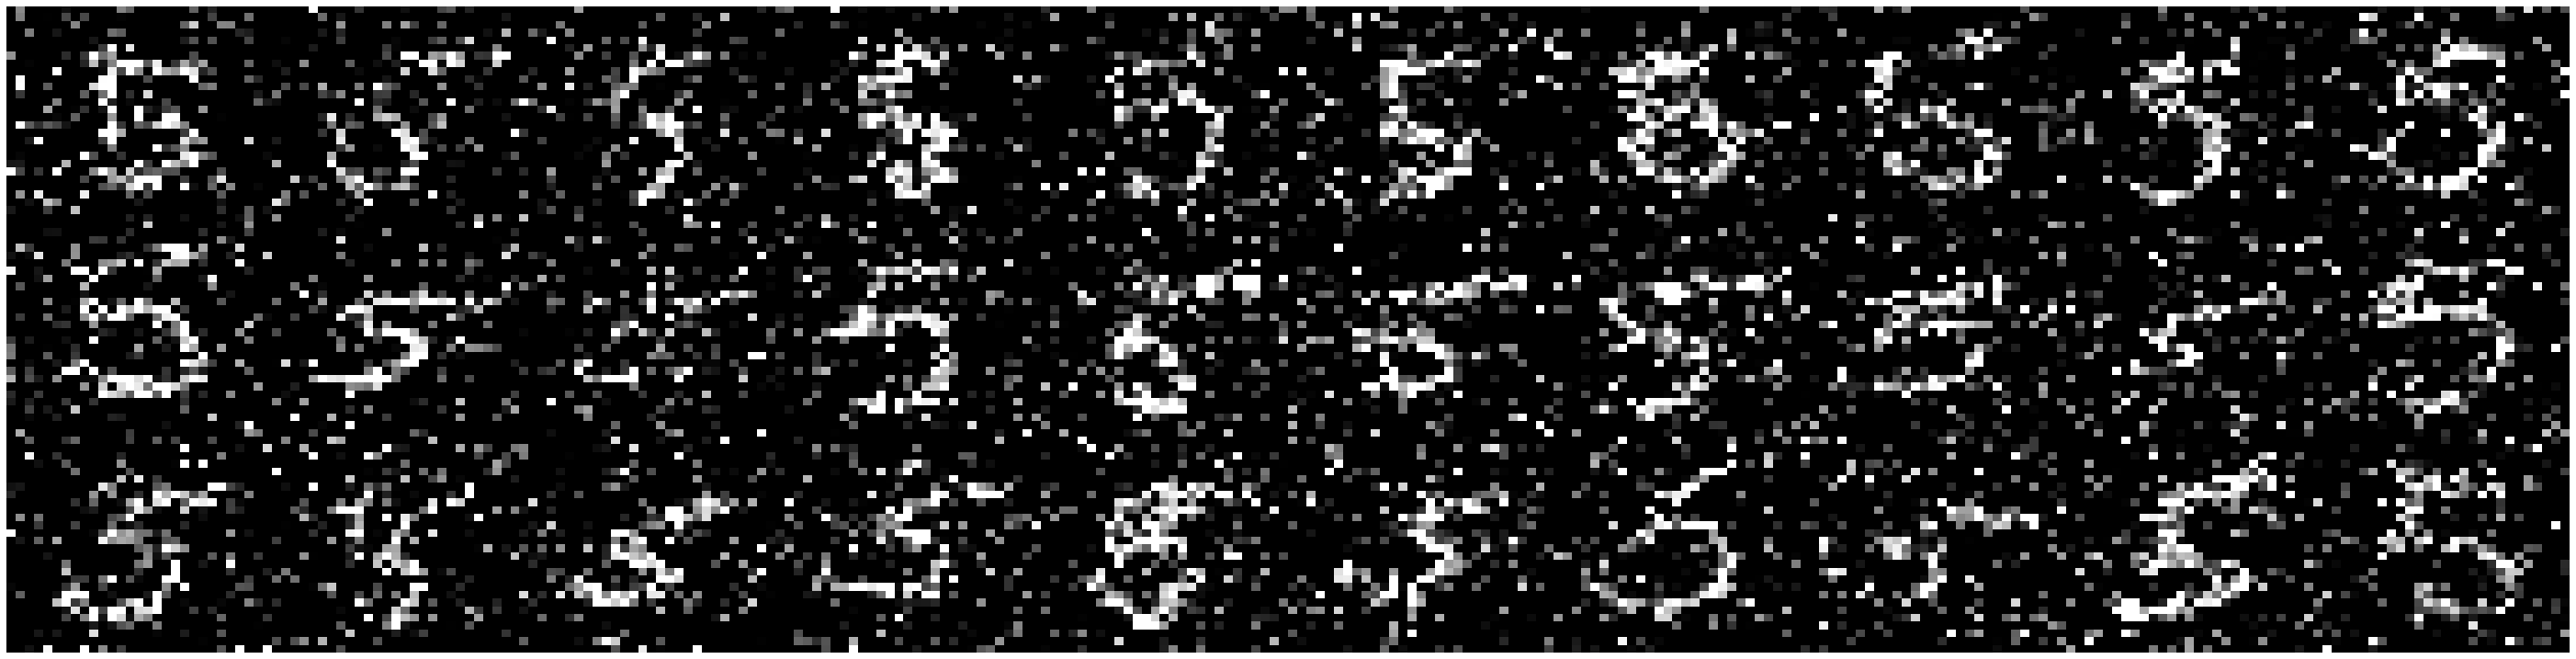

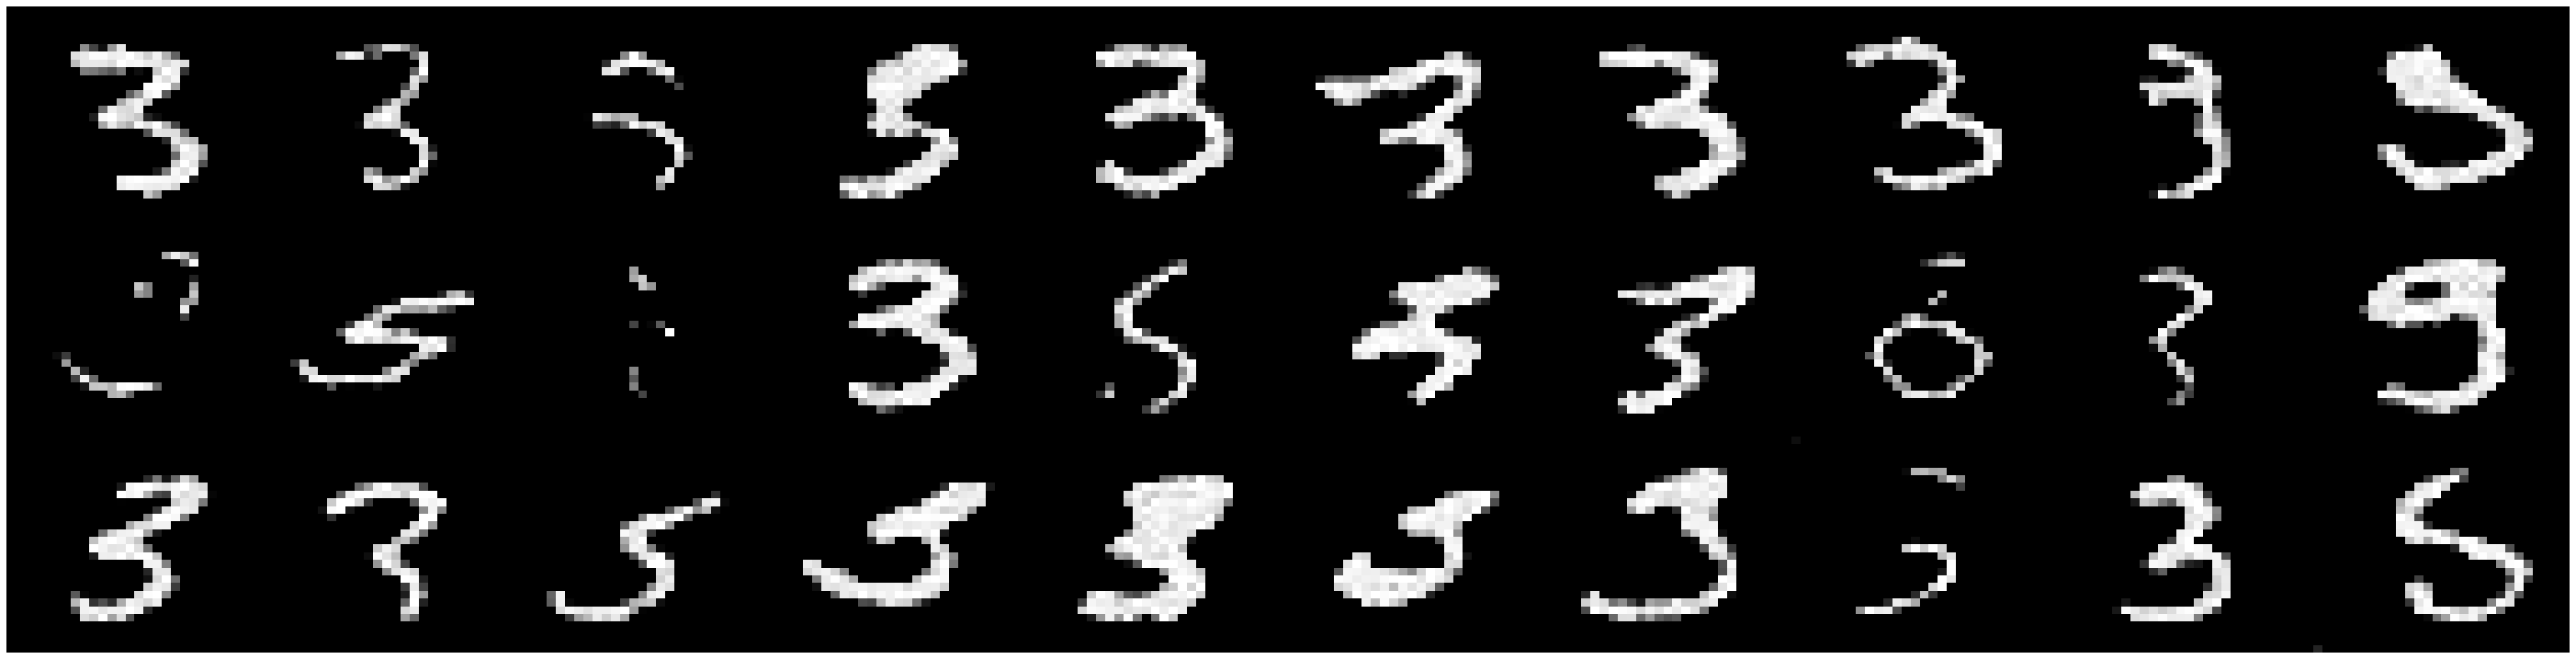

In [14]:
for class_1, class_2, branch_time in branch_point_examples:
    orig_1 = torch.stack([
        torch.tensor(dataset[i][0], device=DEVICE) for i in 
        np.random.choice(np.where(dataset.targets == class_1)[0], size=256, replace=False)
    ])
    orig_2 = torch.stack([
        torch.tensor(dataset[i][0], device=DEVICE) for i in 
        np.random.choice(np.where(dataset.targets == class_2)[0], size=256, replace=False)
    ])
    
    # Order by main slope
    slopes_orig_1 = np.array([get_main_slope(obj[0]) for obj in orig_1.cpu().numpy()])
    slopes_orig_2 = np.array([get_main_slope(obj[0]) for obj in orig_2.cpu().numpy()])
    orig_1 = orig_1[np.argsort(slopes_orig_1)]
    orig_2 = orig_2[np.argsort(slopes_orig_2)]

    # Perform forward diffusion
    time_steps = 10
    all_t = np.linspace(0, branch_time, time_steps)
    forward_1_to_2 = np.empty((len(all_t),) + orig_1.shape)
    backward_1_to_2 = np.empty((len(all_t) - 1,) + orig_1.shape)
    forward_2_to_1 = np.empty((len(all_t),) + orig_1.shape)
    backward_2_to_1 = np.empty((len(all_t) - 1,) + orig_1.shape)
    for t_i, t in enumerate(all_t):
        forward_1_to_2[t_i] = sde.forward(
            orig_1, torch.ones(len(orig_1)).to(DEVICE) * t
        )[0].cpu().numpy()
        forward_2_to_1[t_i] = sde.forward(
            orig_2, torch.ones(len(orig_2)).to(DEVICE) * t
        )[0].cpu().numpy()

    # Perform backward diffusion
    all_t_flip = np.flip(all_t)
    last_1_to_2 = torch.tensor(forward_1_to_2[-1]).to(DEVICE).float()
    last_2_to_1 = torch.tensor(forward_2_to_1[-1]).to(DEVICE).float()
    for t_i in range(len(all_t_flip) - 1):
        last_1_to_2 = generate.generate_continuous_branched_samples(
            model, sde, class_2, class_time_to_branch_tensor, sampler="pc",
            t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
            num_samples=orig_1.shape[0], initial_samples=last_1_to_2,
            num_steps=50
        )
        backward_1_to_2[t_i] = last_1_to_2.cpu().numpy()

        last_2_to_1 = generate.generate_continuous_branched_samples(
            model, sde, class_1, class_time_to_branch_tensor, sampler="pc",
            t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
            num_samples=orig_2.shape[0], initial_samples=last_2_to_1,
            num_steps=50
        )
        backward_2_to_1[t_i] = last_2_to_1.cpu().numpy()

    print("Class %d to %d" % (class_1, class_2))
    plot_inds = np.arange(0, len(orig_1), len(orig_1) // 30)
    fig = plot_mnist_digits(forward_1_to_2[0][plot_inds], grid_size=(10, 3), scale=5)
#     fig.savefig(
#         os.path.join(out_path, "mnist_transmutation_%d_to_%d_before.svg" % (class_1, class_2)),
#         format="svg"
#     )
    fig = plot_mnist_digits(forward_1_to_2[-1][plot_inds], grid_size=(10, 3), scale=5)
#     fig.savefig(
#         os.path.join(out_path, "mnist_transmutation_%d_to_%d_middle.svg" % (class_1, class_2)),
#         format="svg"
#     )
    fig = plot_mnist_digits(backward_1_to_2[-1][plot_inds], grid_size=(10, 3), scale=5)
#     fig.savefig(
#         os.path.join(out_path, "mnist_transmutation_%d_to_%d_after.svg" % (class_1, class_2)),
#         format="svg"
#     )

    print("Class %d to %d" % (class_2, class_1))
    plot_inds = np.arange(0, len(orig_1), len(orig_1) // 30)
    fig = plot_mnist_digits(forward_2_to_1[0][plot_inds], grid_size=(10, 3), scale=5)
#     fig.savefig(
#         os.path.join(out_path, "mnist_transmutation_%d_to_%d_before.svg" % (class_2, class_1)),
#         format="svg"
#     )
    fig = plot_mnist_digits(forward_2_to_1[-1][plot_inds], grid_size=(10, 3), scale=5)
#     fig.savefig(
#         os.path.join(out_path, "mnist_transmutation_%d_to_%d_middle.svg" % (class_2, class_1)),
#         format="svg"
#     )
    fig = plot_mnist_digits(backward_2_to_1[-1][plot_inds], grid_size=(10, 3), scale=5)
#     fig.savefig(
#         os.path.join(out_path, "mnist_transmutation_%d_to_%d_after.svg" % (class_2, class_1)),
#         format="svg"
#     )

### Branch averages

In [15]:
def generate_mix(
    model, sde, classes_to_sample, class_mapper,
    num_samples=64, num_steps=500, t_start=0.001, t_limit=1,
    initial_samples=None, verbose=False
):
    # First, sample from the prior distribution at some late time t
    if initial_samples is not None:
        xt = initial_samples
    else:
        t = (torch.ones(num_samples) * t_limit).to(DEVICE)
        xt = sde.sample_prior(num_samples, t)

    classes_tens = torch.tensor(classes_to_sample, device=DEVICE)
    
    # Disable gradient computation in model
    torch.set_grad_enabled(False)
    
    # Predictor-Corrector
    time_steps = torch.linspace(t_limit, t_start, num_steps).to(DEVICE)
    # (descending order)
    step_size = time_steps[0] - time_steps[1]

    # Step backward through time starting at xt
    x = xt
    t_iter = tqdm.tqdm(time_steps) if verbose else time_steps
    for time_step in t_iter:
        t = torch.ones(num_samples).to(DEVICE) * time_step

        # Take Langevin MCMC step
        branch_inds = class_mapper(classes_tens, torch.tile(time_step, classes_tens.shape))
        score = torch.mean(model(x, t, branch_inds), dim=1)

        snr = 0.1
        score_norm = torch.mean(
            torch.norm(score.reshape(score.shape[0], -1), dim=-1)
        )
        alpha = snr * (
            torch.prod(torch.tensor(x.shape[1:])) / torch.square(score_norm)
        )

        x = x + ((alpha / 2) * score) + \
            (torch.sqrt(alpha) * torch.randn_like(x))

        # Take SDE step
        f = sde.drift_coef_func(x, t)
        g = sde.diff_coef_func(x, t)
        dw = torch.randn_like(x)
        
        score = torch.mean(model(x, t, branch_inds), dim=1)

        drift = (f - (torch.square(g) * score)) * step_size
        diff = g * torch.sqrt(step_size) * dw

        mean_x = x - drift  # Subtract because step size is really negative
        x = mean_x + diff

    return mean_x  # Last step: don't include the diffusion/randomized term

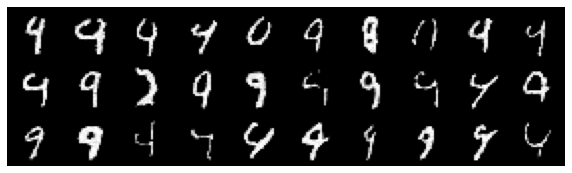

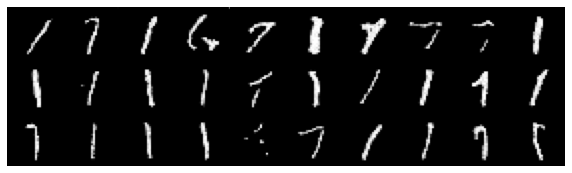

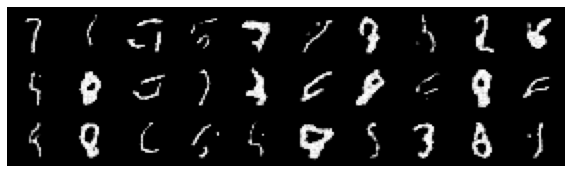

In [16]:
s = generate_mix(
    model, sde, [4, 9], class_time_to_branch_tensor
).cpu().numpy()
fig = plot_mnist_digits(s, grid_size=(10, 3), scale=1)
plt.show()

s = generate_mix(
    model, sde, [1, 7], class_time_to_branch_tensor
).cpu().numpy()
fig = plot_mnist_digits(s, grid_size=(10, 3), scale=1)
plt.show()

s = generate_mix(
    model, sde, list(range(10)), class_time_to_branch_tensor
).cpu().numpy()
fig = plot_mnist_digits(s, grid_size=(10, 3), scale=1)
plt.show()